# Projeto Integrador 1: Pós - graduação CDS - PA

## O Problema de Negócio:

### Contexto:

Os canais de reserva de hotéis online transformaram significativamente a maneira como os clientes fazem suas reservas e também o comportamento deles em relação a essas reservas. 

Atualmente, um número considerável de reservas são canceladas, seja por decisão dos clientes ou por não comparecimento.  

Os motivos típicos para cancelamentos incluem mudanças de planos, 
conflitos de horários, entre outros. 

Muitas vezes, esses cancelamentos 
são facilitados pela opção de cancelar gratuitamente ou a um custo 
muito baixo. 

Embora essa flexibilidade seja benéfica para os hóspedes, 
representando uma comodidade e segurança em suas reservas, para os 
hotéis, isso pode se traduzir em um desafio financeiro e operacional.

### Objetivo:

Nesse contexto, você trabalha como Cientista de Dados para a empresa fictícia HotelSmart e o CEO está preocupado com a alta taxa de cancelamento de reservas, que tem um custo médio de R$3500 por 
cancelamento. Com a estimativa de 50,000 reservas para o próximo ano, os cancelamentos representam um desafio significativo tanto financeiro quanto operacional.

O objetivo deste desafio é desenvolver um modelo de Machine Learning capaz de prever com precisão se uma reserva será cancelada ou não. 

A previsão precisa dos cancelamentos permitirá à HotelSmart adotar medidas proativas para reduzir o impacto dos cancelamentos, otimizar a ocupação dos quartos e, consequentemente, aumentar a lucratividade.

## Planejamento:

### Método SAPE:

- Saída: 

Página onde será possível digitar as características do cliente e ter o resultado se será cancelar a reserva ou não.

- Etapas do Processo (método SAPE):

1) Entendimento do Problema de Negócio
2) Coletar os dados
3) Análise Descritiva dos dados
	- Tipo de dado
	- Verificar NA
	- Tratamento de NA

4) Feature Engineering
	- feature 1
	- feature 2
	- feature n

5) Análise Exploratória dos Dados

6) Preparação dos dados
	- Transformação dos dados categóricos
	- Ajustar a escala dos dados

7) Treinamento de Algoritmos
	- Random Forest
	- Regressão Logística

8) Avaliar o erro do modelo

9) Ajuste fino dos parâmetros

10) Construir minha API para deploy

11) Fazer o deploy do projeto em um ambiente Cloud

## Imports:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.impute import KNNImputer
from IPython.display import Image
from IPython.core.display import HTML
from scipy import stats as ss
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import association_metrics as am
import warnings
from sklearn.linear_model import Lasso, Ridge
from boruta import BorutaPy
from sklearn import metrics as mt
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from bayes_opt import BayesianOptimization
import pickle
from matplotlib.ticker import FuncFormatter


## Funções:

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.container {width: 100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.set_option('display.expand_frame_repr', False)

    sns.set()

jupyter_settings()

def calculate_metrics(nome_algoritmo, y_true, y_pred):
    precision = mt.precision_score(y_true, y_pred)
    recall = mt.recall_score(y_true, y_pred)
    accuracy = mt.accuracy_score(y_true, y_pred)

    df = pd.DataFrame({
        'Algoritmo': [nome_algoritmo],
        'Precisão': [precision],
        'Recall': [recall],
        'Acurácia': [accuracy]
    })

    return df

def cross_validation_kfold(model, X, y):
    num_folds = 5
    scores = ['precision', 'recall']
    kfold = KFold(num_folds, shuffle = True, random_state = 42)

    score_results = cross_validate(model, X, y, scoring = scores, cv = kfold)
    model_name = model.__class__.__name__
    precision_mean = score_results['test_precision'].mean()
    recall_mean = score_results['test_recall'].mean()

    result_dict = {'model': model_name,
                   'precision': precision_mean,
                   'recall': recall_mean}
    result_dict = pd.DataFrame([result_dict])

    return result_dict

def rescale_columns(data, column_names, scaler_type='robust'):
    for col in column_names:
        if col not in data.columns:
            print(f"Atenção: coluna '{col}' não encontrada no DataFrame.")
            continue

        if scaler_type in ['robust', 'minmax']:
            scalers = {
                'robust': RobustScaler(),
                'minmax': MinMaxScaler()
            }
            scaler = scalers[scaler_type]
            data[[col]] = scaler.fit_transform(data[[col]])
            pickle.dump(scaler, open(f'parameter/{col}_{scaler_type}.pkl', 'wb'))

        elif scaler_type == 'label':
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])
            pickle.dump(le, open(f'parameter/{col}_labelencoder.pkl', 'wb'))

        else:
            raise ValueError(f"Scaler '{scaler_type}' não é suportado.")

    return data

def cramer_v(x, y): #correlação entre variáveis categóricas: V de Cramer
    cm = pd.crosstab(x, y).values             #tabela de contingência
    n = cm.sum()                              # n = número total de observações
    r, k = cm.shape                           # r = número de linhas, k = número de colunas
    
    chi2 = ss.chi2_contingency( cm )[0]                  #calculando o qui quadrado de Peason a partir de uma tabela de contingência
    chi2corr = max( 0, chi2 - (k - 1)*(r - 1) / (n - 1))    #corrigindo o viés do V de Cramer
    kcorr = k - ((k - 1)**2) / (n - 1)
    rcorr = r - ((r - 1)**2) / (n - 1)
    
    return np.sqrt( (chi2corr/n) / (min(kcorr - 1, rcorr - 1  ) ) )

def estatisticas(df):
    'função para calcular as estatísticas de um conjunto de dados'
    estatisticas = df.describe().T.reset_index()
    estatisticas.columns = ['feature','quantidade','média','desvio-padrão', 
                            'minimo','1Q','2Q','3Q','máximo']
    estatisticas['mediana'] = estatisticas['2Q']
    estatisticas['IQR'] = estatisticas['3Q'] - estatisticas['1Q']
    return estatisticas

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 1.0 Dataset:

In [3]:
dados = pd.read_csv("hotel.csv")

In [4]:
dados.columns

Index(['Booking_ID', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status'],
      dtype='object')

In [5]:
dados.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [6]:
dados['market_segment_type'].unique()

array(['Offline', 'Online', 'Corporate', 'Aviation', 'Complementary'],
      dtype=object)

### 1.1 Descrição dos Dados

In [7]:
df1 = dados.copy()

### 1.2 Dimensão dos Dados:

In [8]:
df1.shape

(36275, 19)

In [9]:
df1['Booking_ID'].nunique()

36275

### 1.3 Tipo dos Dados:

In [10]:
df1.dtypes

Booking_ID                               object
no_of_adults                              int64
no_of_children                            int64
no_of_weekend_nights                      int64
no_of_week_nights                         int64
type_of_meal_plan                        object
required_car_parking_space                int64
room_type_reserved                       object
lead_time                                 int64
arrival_year                              int64
arrival_month                             int64
arrival_date                              int64
market_segment_type                      object
repeated_guest                            int64
no_of_previous_cancellations              int64
no_of_previous_bookings_not_canceled      int64
avg_price_per_room                      float64
no_of_special_requests                    int64
booking_status                           object
dtype: object

### 1.4 Dados faltantes (NA):

In [11]:
df1.isna().sum()

Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

### 1.5 Estatística Descritiva

#### 1.5.1 Dados Numéricos:

In [12]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])

In [13]:
#medidas de tendencia central

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#medidas de dispersão
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T   #range
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T        #curtose

#percentis
percentil25 = pd.DataFrame(num_attributes.apply(lambda x: np.percentile(x,25))).T
percentil50 = pd.DataFrame(num_attributes.apply(lambda x: np.percentile(x,50))).T
percentil75 = pd.DataFrame(num_attributes.apply(lambda x: np.percentile(x,75))).T
percentil85 = pd.DataFrame(num_attributes.apply(lambda x: np.percentile(x,85))).T
percentil90 = pd.DataFrame(num_attributes.apply(lambda x: np.percentile(x,90))).T
percentil99 = pd.DataFrame(num_attributes.apply(lambda x: np.percentile(x,99))).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, percentil25, percentil50, percentil75, percentil85, percentil90, percentil99]).T.reset_index()

m.columns = ['coluna', 'min','max', 'range', 'media', 'mediana', 'desvio_padrao', 'skew', 'kurtosis', 
             'percentil_25', 'percentil_50', 'percentil_75', 'percentil_85', 'percentil_90', 'percentil_99']


In [14]:
m

,coluna,min,max,range,media,mediana,desvio_padrao,skew,kurtosis,percentil_25,percentil_50,percentil_75,percentil_85,percentil_90,percentil_99
0,no_of_adults,0.0,4.0,4.0,1.844962,2.00,0.518708,-0.333295,0.814822,2.0,2.00,2.0,2.0,2.000,3.0
1,no_of_children,0.0,10.0,10.0,0.105279,0.00,0.402643,4.710350,36.981856,0.0,0.00,0.0,0.0,0.000,2.0
2,no_of_weekend_nights,0.0,7.0,7.0,0.810724,1.00,0.870632,0.737616,0.298858,0.0,1.00,2.0,2.0,2.000,2.0
3,no_of_week_nights,0.0,17.0,17.0,2.204300,2.00,1.410885,1.599350,7.798284,1.0,2.00,3.0,3.0,4.000,6.0
4,required_car_parking_space,0.0,1.0,1.0,0.030986,0.00,0.173278,5.413643,27.309037,0.0,0.00,0.0,0.0,0.000,1.0
5,lead_time,0.0,443.0,443.0,85.232557,57.00,85.929632,1.292492,1.179594,17.0,57.00,126.0,179.0,213.000,346.0
6,arrival_year,2017.0,2018.0,1.0,2017.820427,2018.00,0.383831,-1.669695,0.787926,2018.0,2018.00,2018.0,2018.0,2018.000,2018.0
7,arrival_month,1.0,12.0,11.0,7.423653,8.00,3.069852,-0.348229,-0.933189,5.0,8.00,10.0,11.0,11.000,12.0
8,arrival_date,1.0,31.0,30.0,15.596995,16.00,8.740327,0.028809,-1.157214,8.0,16.00,23.0,26.0,28.000,31.0
9,repeated_guest,0.0,1.0,1.0,0.025637,0.00,0.158051,6.002888,34.036545,0.0,0.00,0.0,0.0,0.000,1.0


#### 1.5.2 Dados Categóricos:

In [15]:
cat_attributes = df1.select_dtypes(include = ['object'])

In [16]:
cat_attributes.describe().T

,count,unique,top,freq
Booking_ID,36275,36275,INN00001,1
type_of_meal_plan,36275,4,Meal Plan 1,27835
room_type_reserved,36275,7,Room_Type 1,28130
market_segment_type,36275,5,Online,23214
booking_status,36275,2,Not_Canceled,24390


## 2.0 Feature Engineering

In [17]:
df2 = df1.copy()

### 2.1 MindMap de Hipóteses

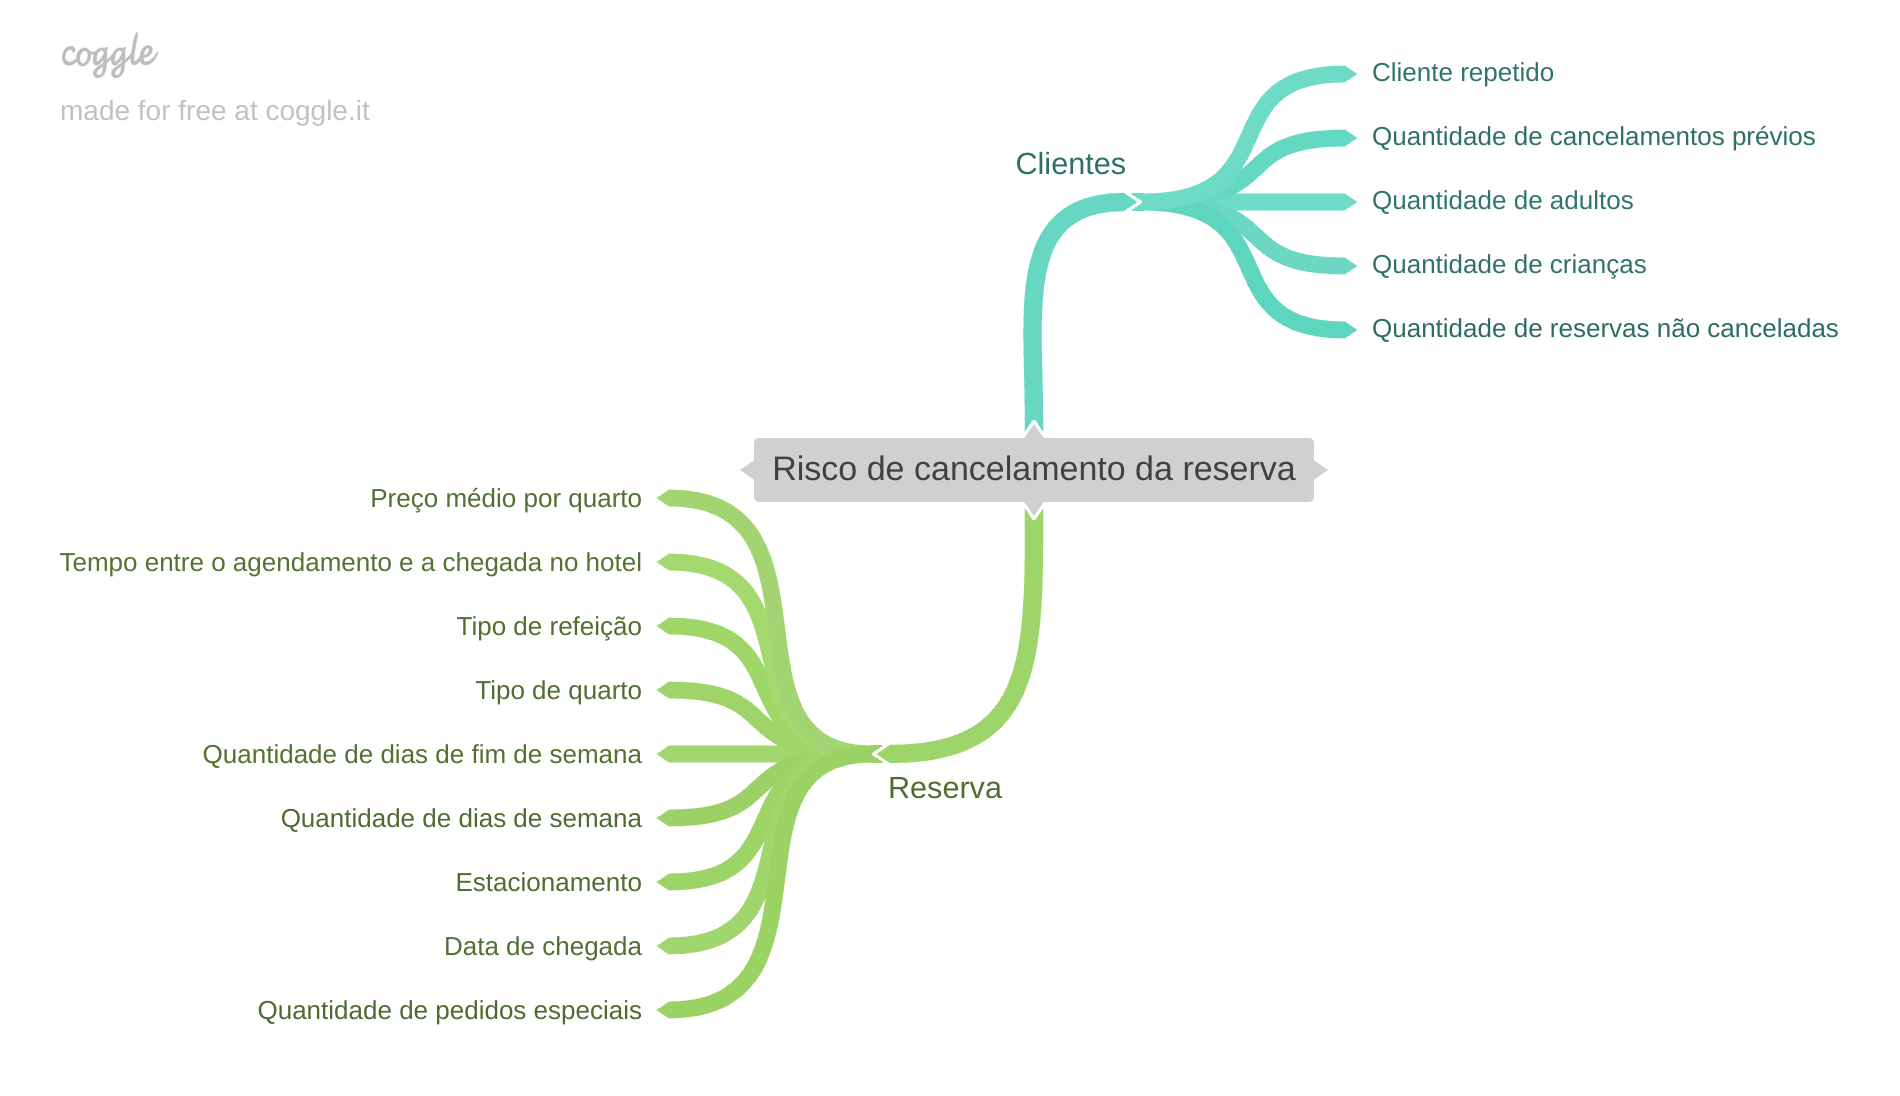

In [18]:
Image('../hotel.png')

### 2.2 Lista de Hipóteses

##### 2.2.1 Hipóteses do Cliente

- Pessoas com cancelamento prévio têm maior probabilidade de cancelar novamente;
- Pessoas com crianças na reserva têm maior probabilidade de cancelamento;
- Pessoas com maior quantidade de adultos na reserva têm menor probabilidade de cancelar;
- Pessoas sem histórico de cancelamento tendem a não cancelar a reserva

##### 2.2.2 Hipóteses da Reserva

- Reservas feitas com muita antecedência tendem a serem canceladas;
- Reservas sem estacionamento tendem a serem canceladas;
- Meses com férias escolares (janeiro, julho e dezembro) tendem a ter mais cancelamentos;
- Quanto maior a quantidade de pedidos especiais, menor a probabilidade de cancelamento;
- Quanto maior o tempo da estada, maior a probabilidade de cancelamento;
- Quanto maior o preço médio do quarto, maior a probabilidade de cancelamento;
- O tipo de quarto tem correlação com o cancelamento;
- O tipo de refeição tem correlação com o cancelamento


### 2.3 Construção de novas features:

In [19]:
#meses de férias escolares:
meses = [1,7,12]
df2['vacation'] = df2['arrival_month'].apply(lambda x: 1 if x in meses else 0)

#proporção de crianças por adultos:
df2['children_per_adults'] = df2.apply(lambda row: row['no_of_children'] / row['no_of_adults'] if row['no_of_adults'] > 0 else 0, axis=1)
df2['children_per_adults'] = df2['children_per_adults'].fillna(0)

#quantidade total de pessoas:
df2['no_total_guests'] = df2['no_of_children'] + df2['no_of_adults']

#quantidade total de dias da reserva:
df2['no_total_days'] = df2['no_of_week_nights'] + df2['no_of_weekend_nights']

#proporção do tempo / qtde de hóspedes:
df2['total_days_per_guests'] = df2['no_total_days'] / df2['no_total_guests']

#proporção média do preço do quarto por total de hóspedes:
df2['price_per_guests'] = df2['avg_price_per_room'] / df2['no_total_guests']

## 3.0 Análise Exploratória dos Dados

In [20]:
df3 = df2.copy()

### 3.1 Análise Univariada

#### 3.1.1 Variável Resposta

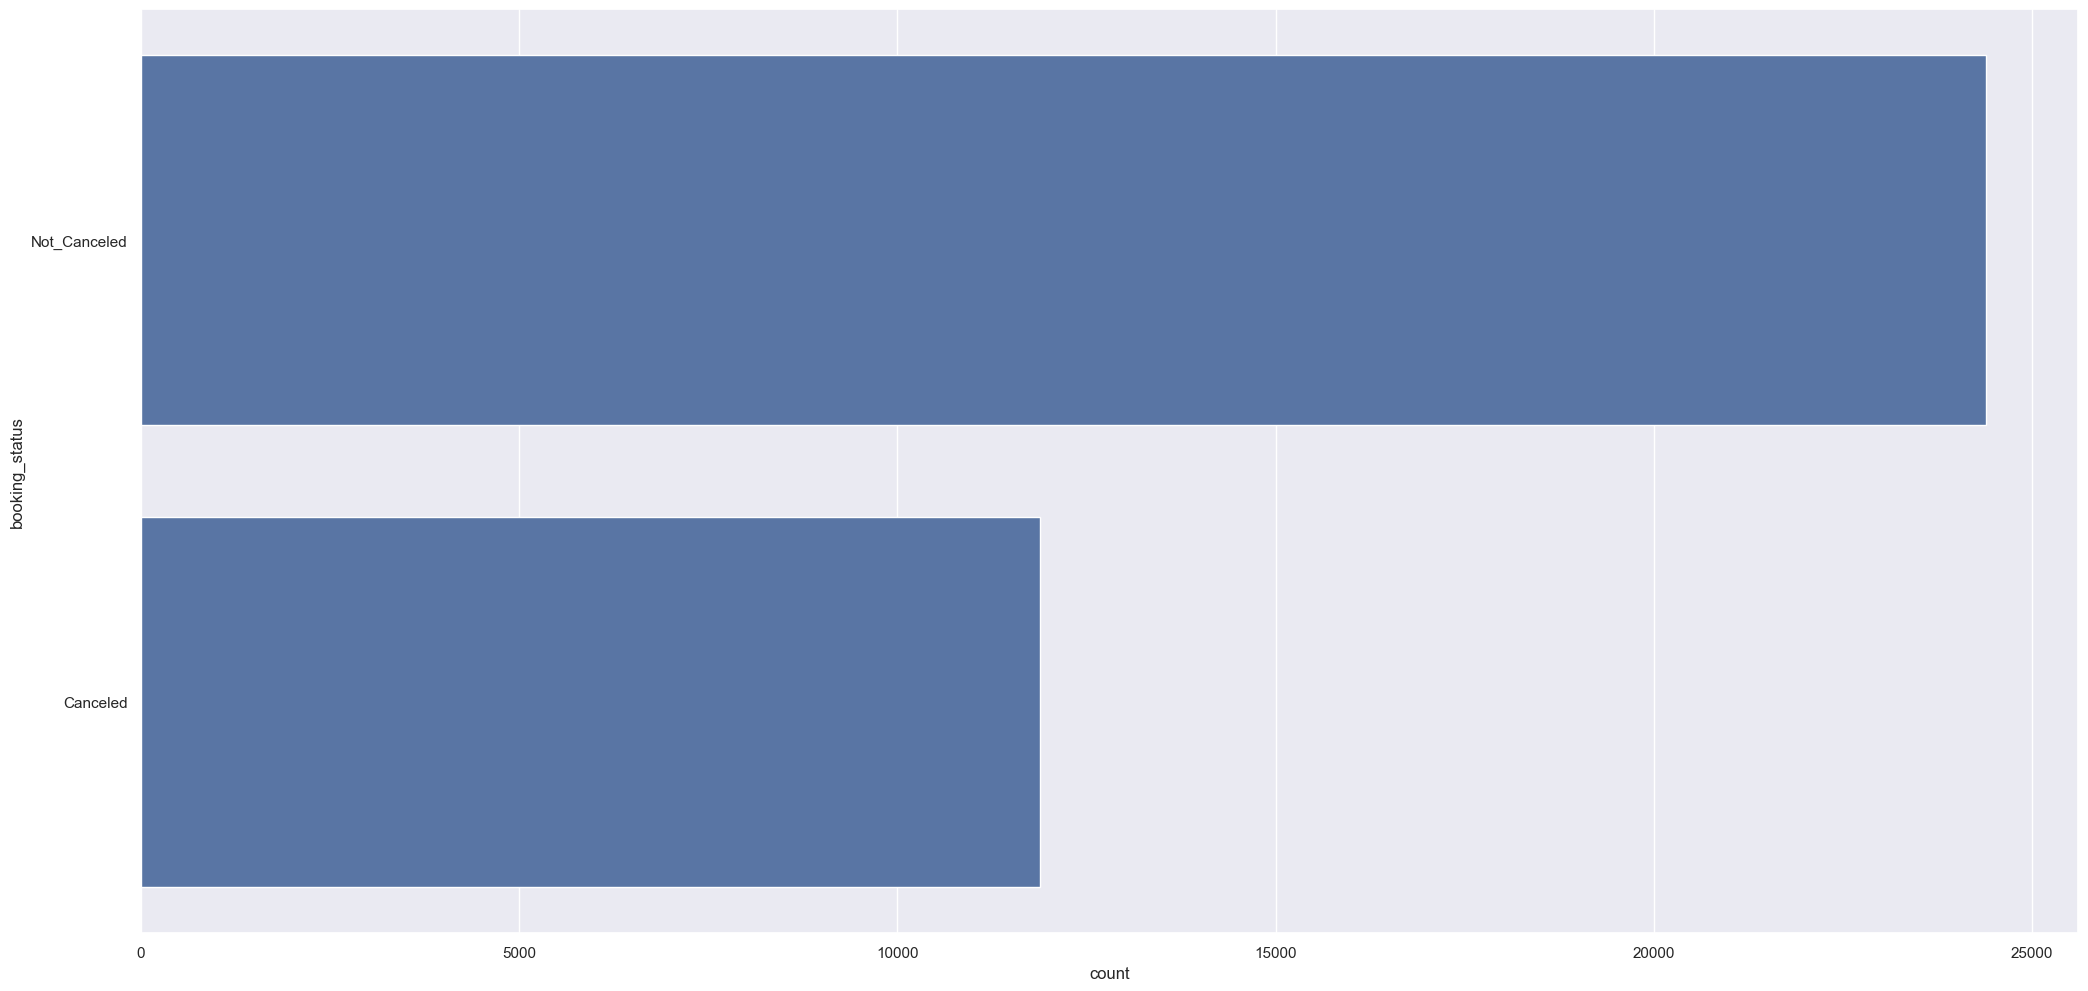

In [21]:
aux = df3.copy()

sns.countplot(aux['booking_status'])
plt.show()

#### 3.1.2 Variáveis Numéricas

In [22]:
num_attributes2 = df3.select_dtypes(exclude = ['category', 'object'])

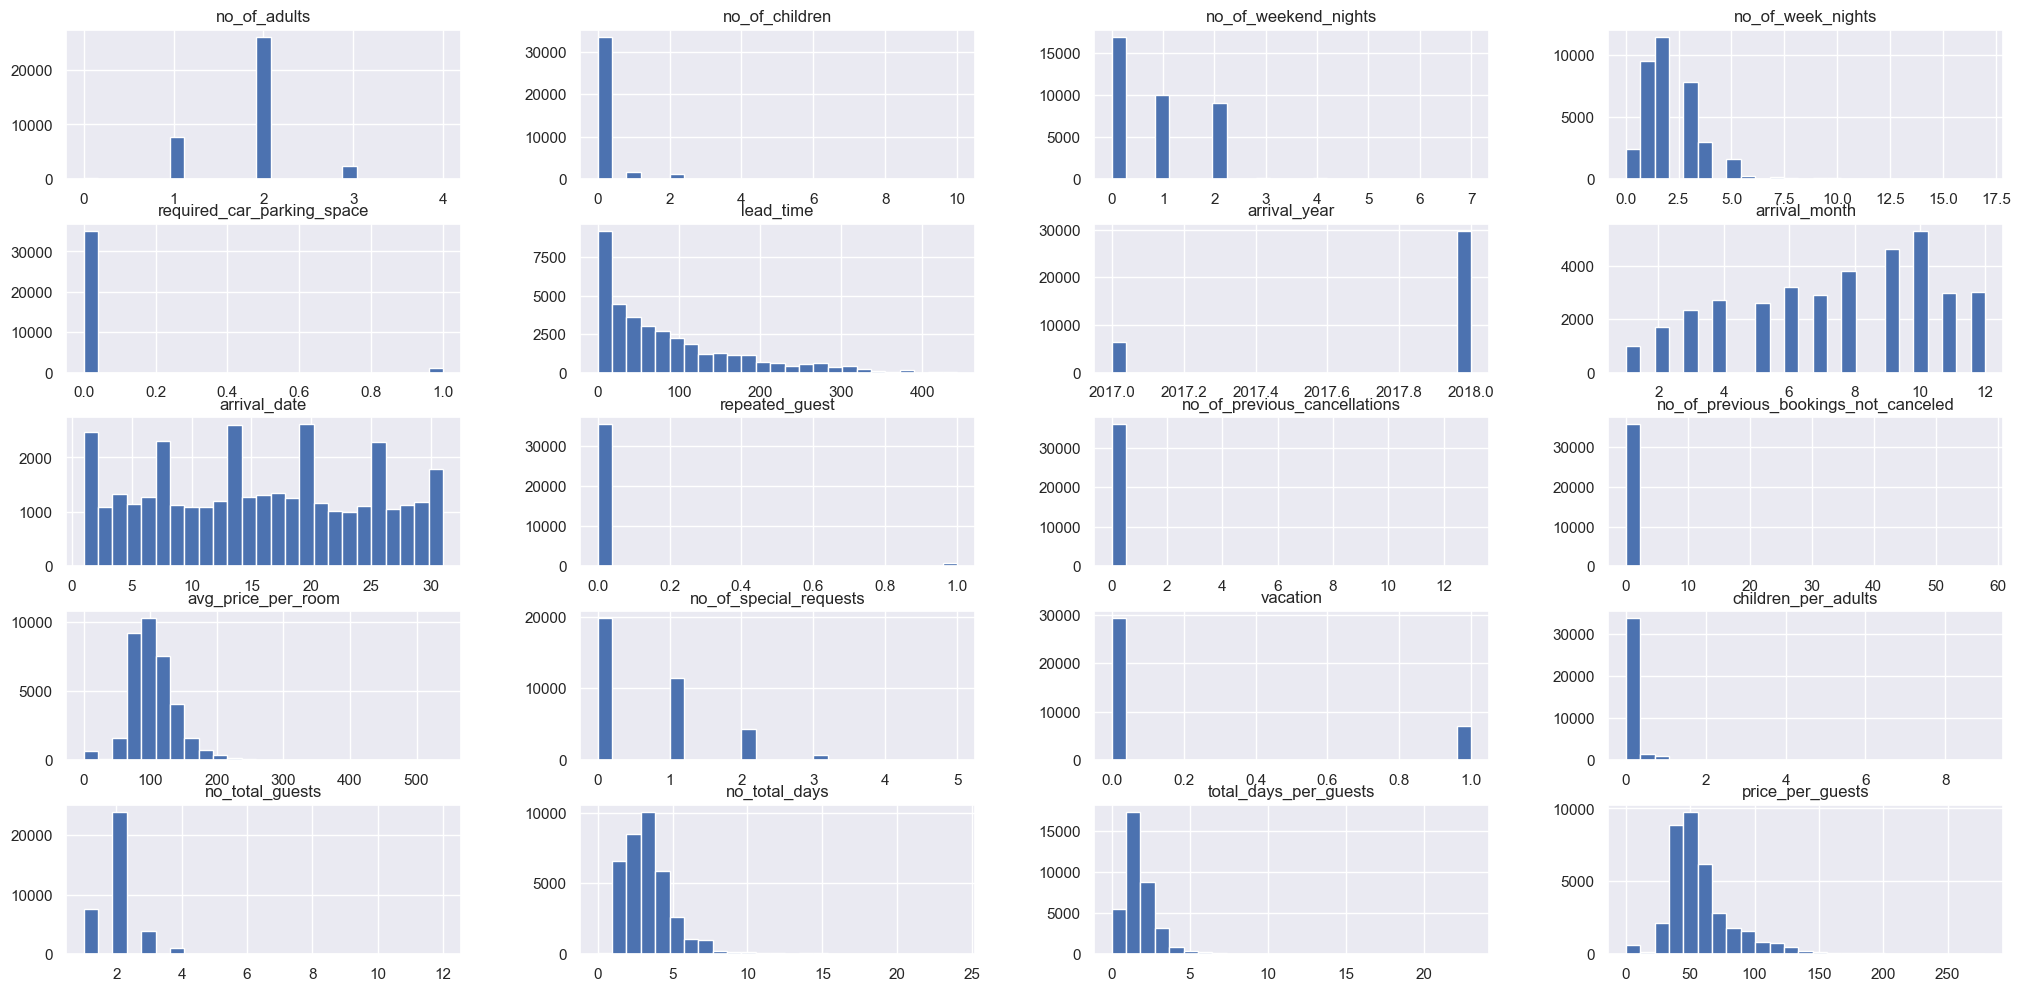

In [23]:
num_attributes2.hist(bins = 25)
plt.show();

#### 3.1.3 Variáveis Categóricas

In [24]:
cat_attributes2 = df3.select_dtypes(include = ['category', 'object'] )

In [25]:
cat_attributes2.describe().T

,count,unique,top,freq
Booking_ID,36275,36275,INN00001,1
type_of_meal_plan,36275,4,Meal Plan 1,27835
room_type_reserved,36275,7,Room_Type 1,28130
market_segment_type,36275,5,Online,23214
booking_status,36275,2,Not_Canceled,24390


##### 3.1.3.1 Tipo de Refeição:

In [26]:
cat_attributes2['type_of_meal_plan'].unique()

array(['Meal Plan 1', 'Not Selected', 'Meal Plan 2', 'Meal Plan 3'],
      dtype=object)

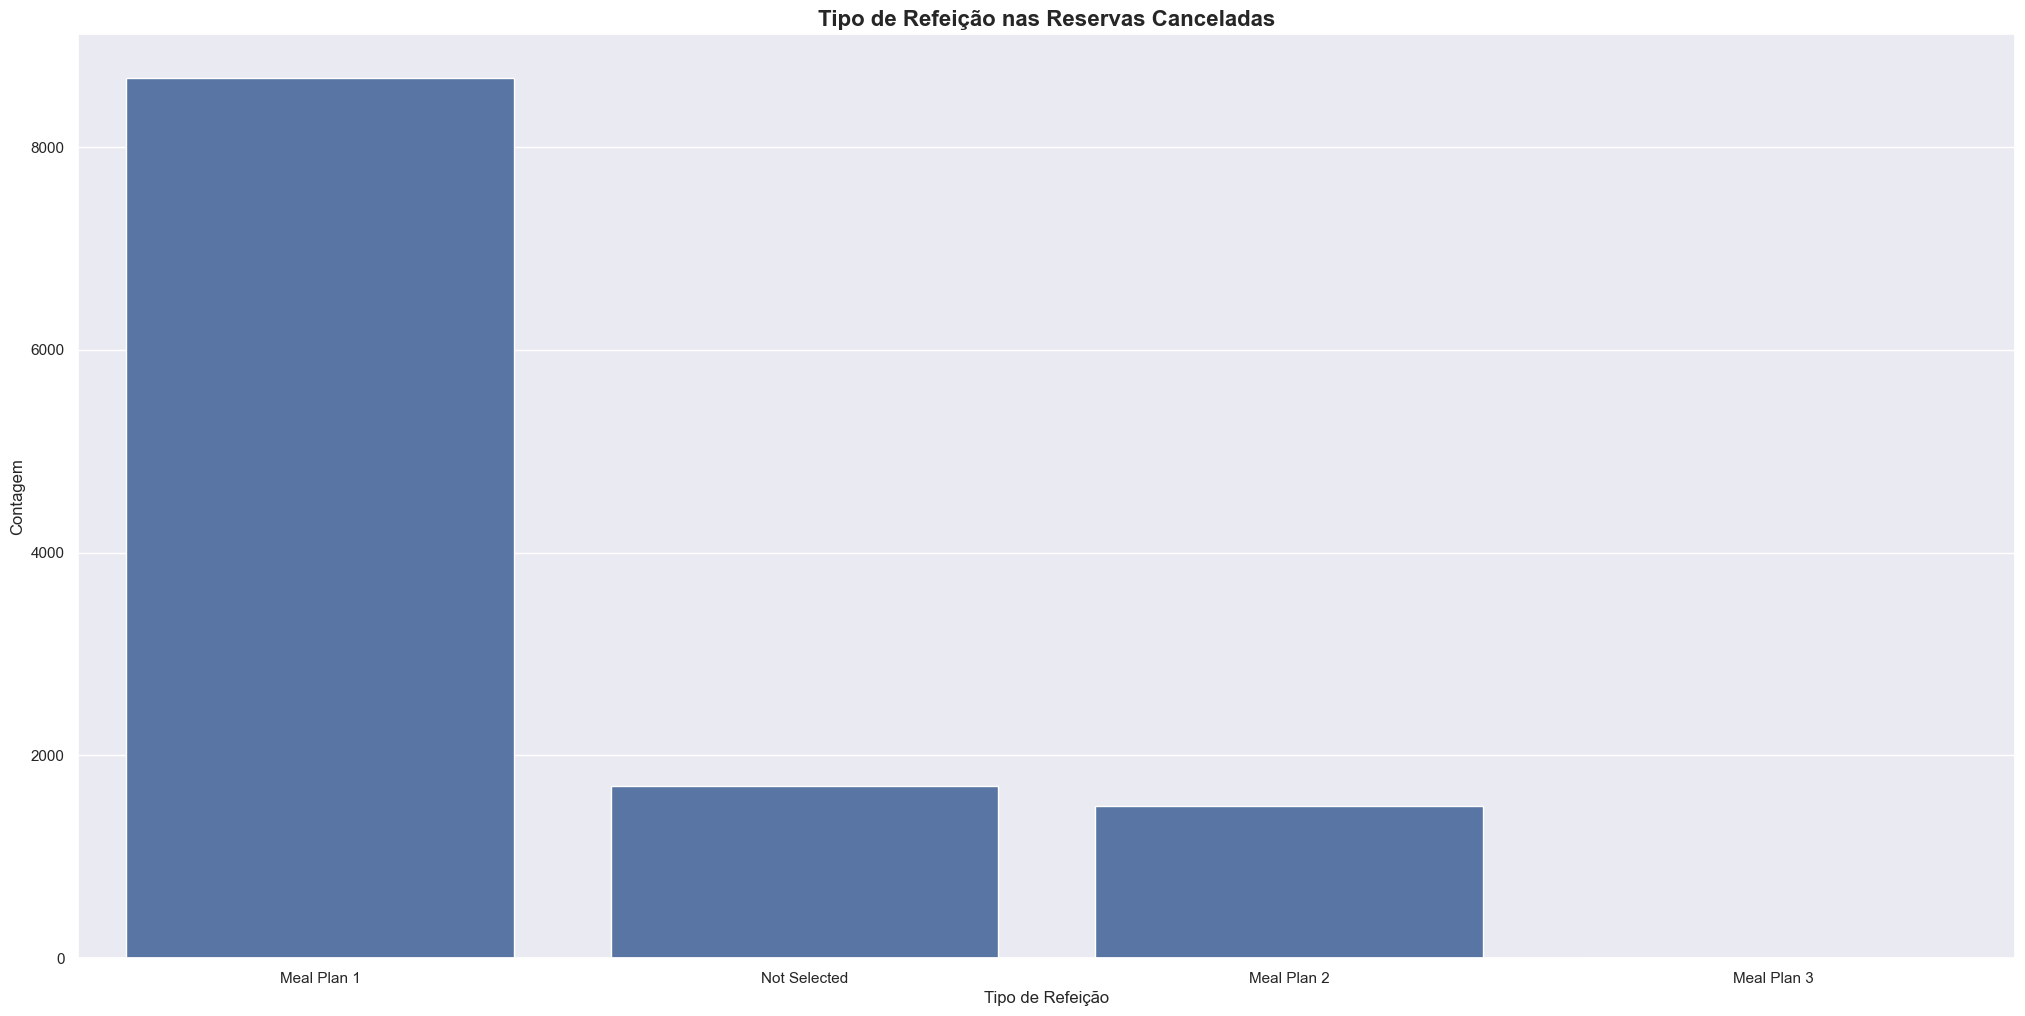

In [27]:
sns.countplot(cat_attributes2[cat_attributes2['booking_status'] == 'Canceled'], x = 'type_of_meal_plan')
plt.title('Tipo de Refeição nas Reservas Canceladas', fontsize = 16, fontweight = 'bold')
plt.xlabel('Tipo de Refeição')
plt.ylabel('Contagem')
plt.show();

##### 3.1.3.2 Tipo de quarto:

In [28]:
cat_attributes2['room_type_reserved'].unique()

array(['Room_Type 1', 'Room_Type 4', 'Room_Type 2', 'Room_Type 6',
       'Room_Type 5', 'Room_Type 7', 'Room_Type 3'], dtype=object)

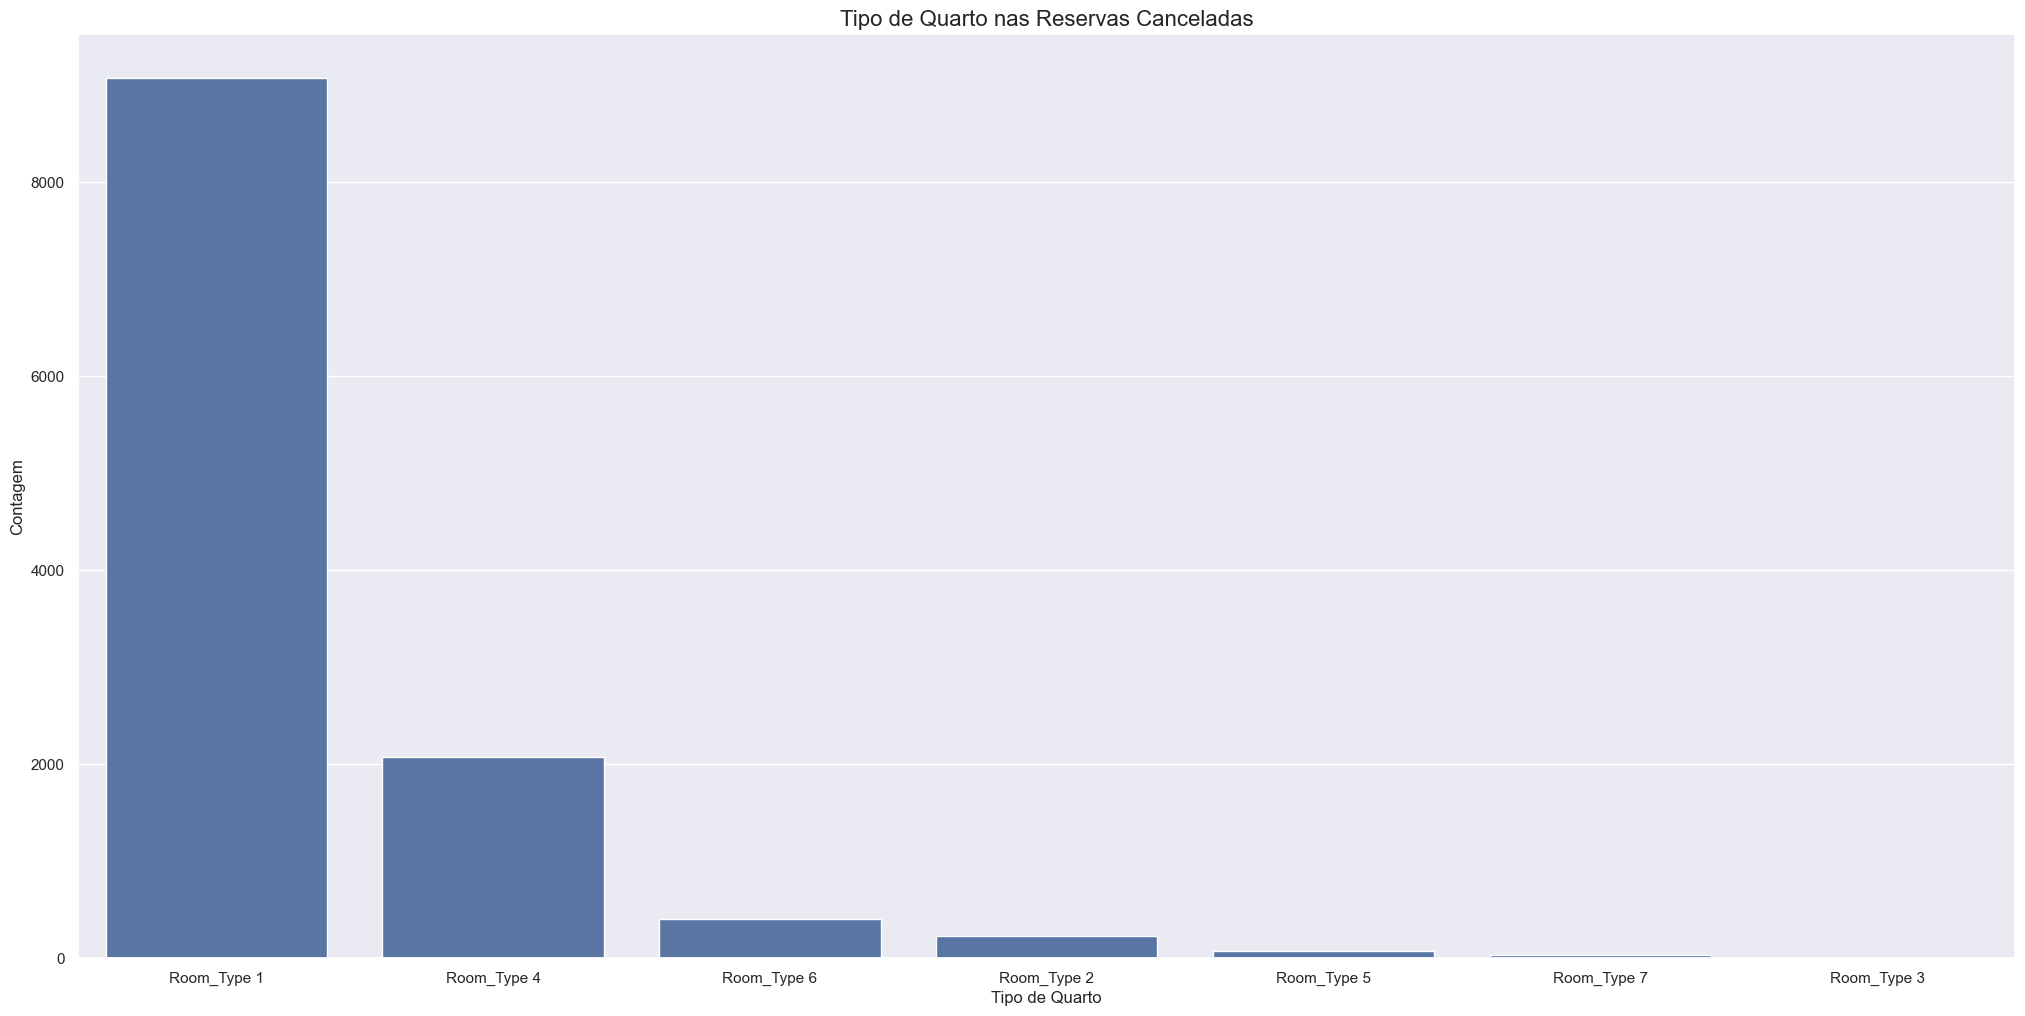

In [29]:
sns.countplot(cat_attributes2[cat_attributes2['booking_status'] == 'Canceled'], x = 'room_type_reserved')
plt.title('Tipo de Quarto nas Reservas Canceladas', fontsize = 16)
plt.xlabel('Tipo de Quarto')
plt.ylabel('Contagem')
plt.show();

##### 3.1.3.3 Segmento de mercado:

In [30]:
cat_attributes2['market_segment_type'].unique()

array(['Offline', 'Online', 'Corporate', 'Aviation', 'Complementary'],
      dtype=object)

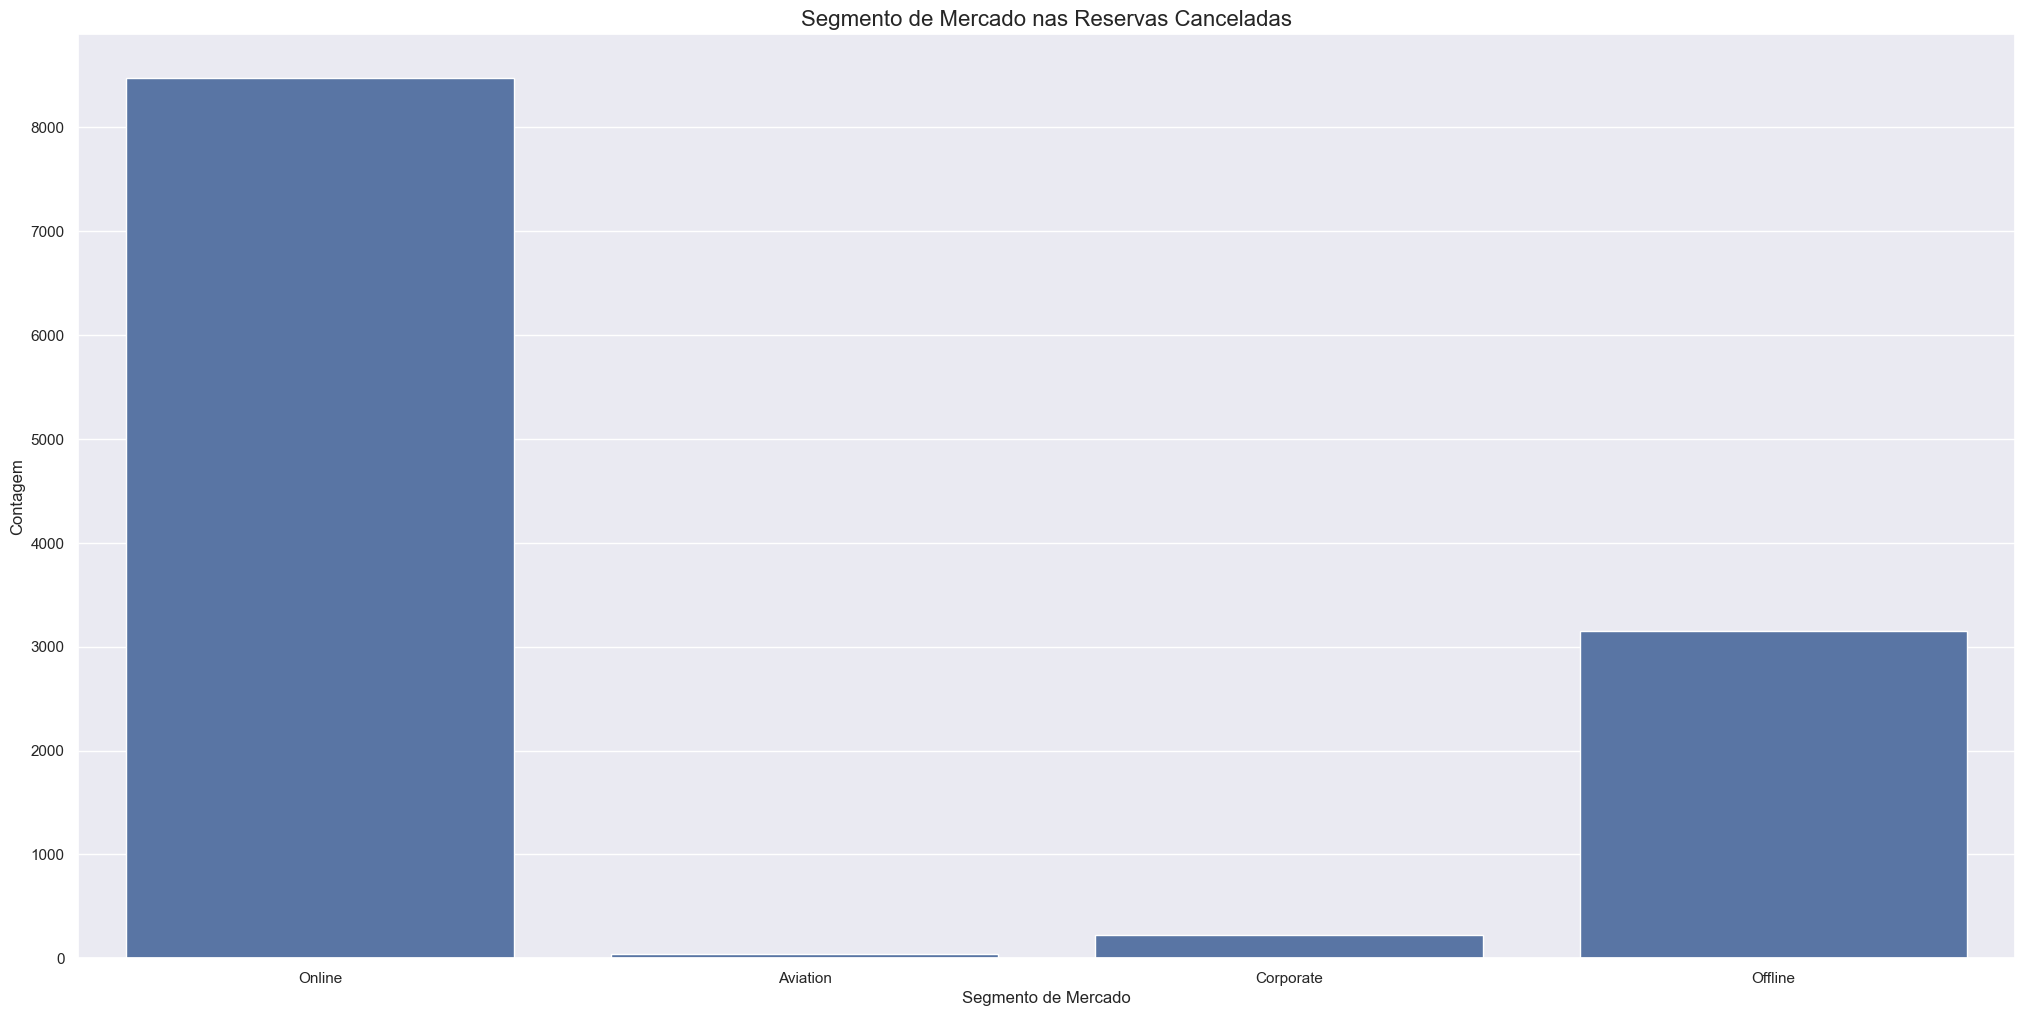

In [31]:
sns.countplot(cat_attributes2[cat_attributes2['booking_status'] == 'Canceled'], x = 'market_segment_type')
plt.title('Segmento de Mercado nas Reservas Canceladas', fontsize = 16)
plt.xlabel('Segmento de Mercado')
plt.ylabel('Contagem')
plt.show();

##### Insigths da Análise Univariada:

- A base de dados é desbalanceada, pois apenas 32,76% das reservas foram canceladas;
- Não há números de reservas em duplicidade na base;
- A feature média de preços por quarto parece se aproximar da distribuição normal;
- O tipo de quarto mais cancelado é o Tipo 1,
- O segmento que mais cancela é o 'Online',
- O tipo de refeição mais comum nos cancelamentos é a Meal Plan 1.

### 3.2 Análise Bivariada

#### 3.2.1 Hipóteses do Cliente

##### - Pessoas com cancelamento prévio têm maior probabilidade de cancelar novamente

NÃO FOI POSSÍVEL CONCLUIR.

Há mais pessoas que não cancelaram a reserva (booking_status = Not_Canceled) com histórico de cancelamento. 

Porém, o desvio-padrão e a média são maiores no grupo do 'booking_status' = 'Canceled', e a quantidade máxima também (13).

O grupo com 'booking_status' = 'Canceled' e com histórico de canccelamento é muito pequeno: apenas 16 pessoas.

Neste momento, não foi possível concluir se as pessoas com cancelamento prévio têm maior probabilidade de cancelar novamente. 

Será feito teste de hipótese no próximo ciclo Crisp.

In [32]:
#Analisando somente os clientes com cancelamento prévio:

aux = df3[df3['no_of_previous_cancellations'] > 0][['booking_status', 'no_of_previous_cancellations']]

In [33]:
canceled = aux[aux['booking_status'] == 'Canceled']

estatisticas(canceled)

,feature,quantidade,média,desvio-padrão,minimo,1Q,2Q,3Q,máximo,mediana,IQR
0,no_of_previous_cancellations,16.0,4.125,5.315073,1.0,1.0,1.0,5.5,13.0,1.0,4.5


In [34]:
not_canceled = aux[aux['booking_status'] == 'Not_Canceled']

estatisticas(not_canceled)

,feature,quantidade,média,desvio-padrão,minimo,1Q,2Q,3Q,máximo,mediana,IQR
0,no_of_previous_cancellations,322.0,2.425466,2.70612,1.0,1.0,1.0,3.0,11.0,1.0,2.0


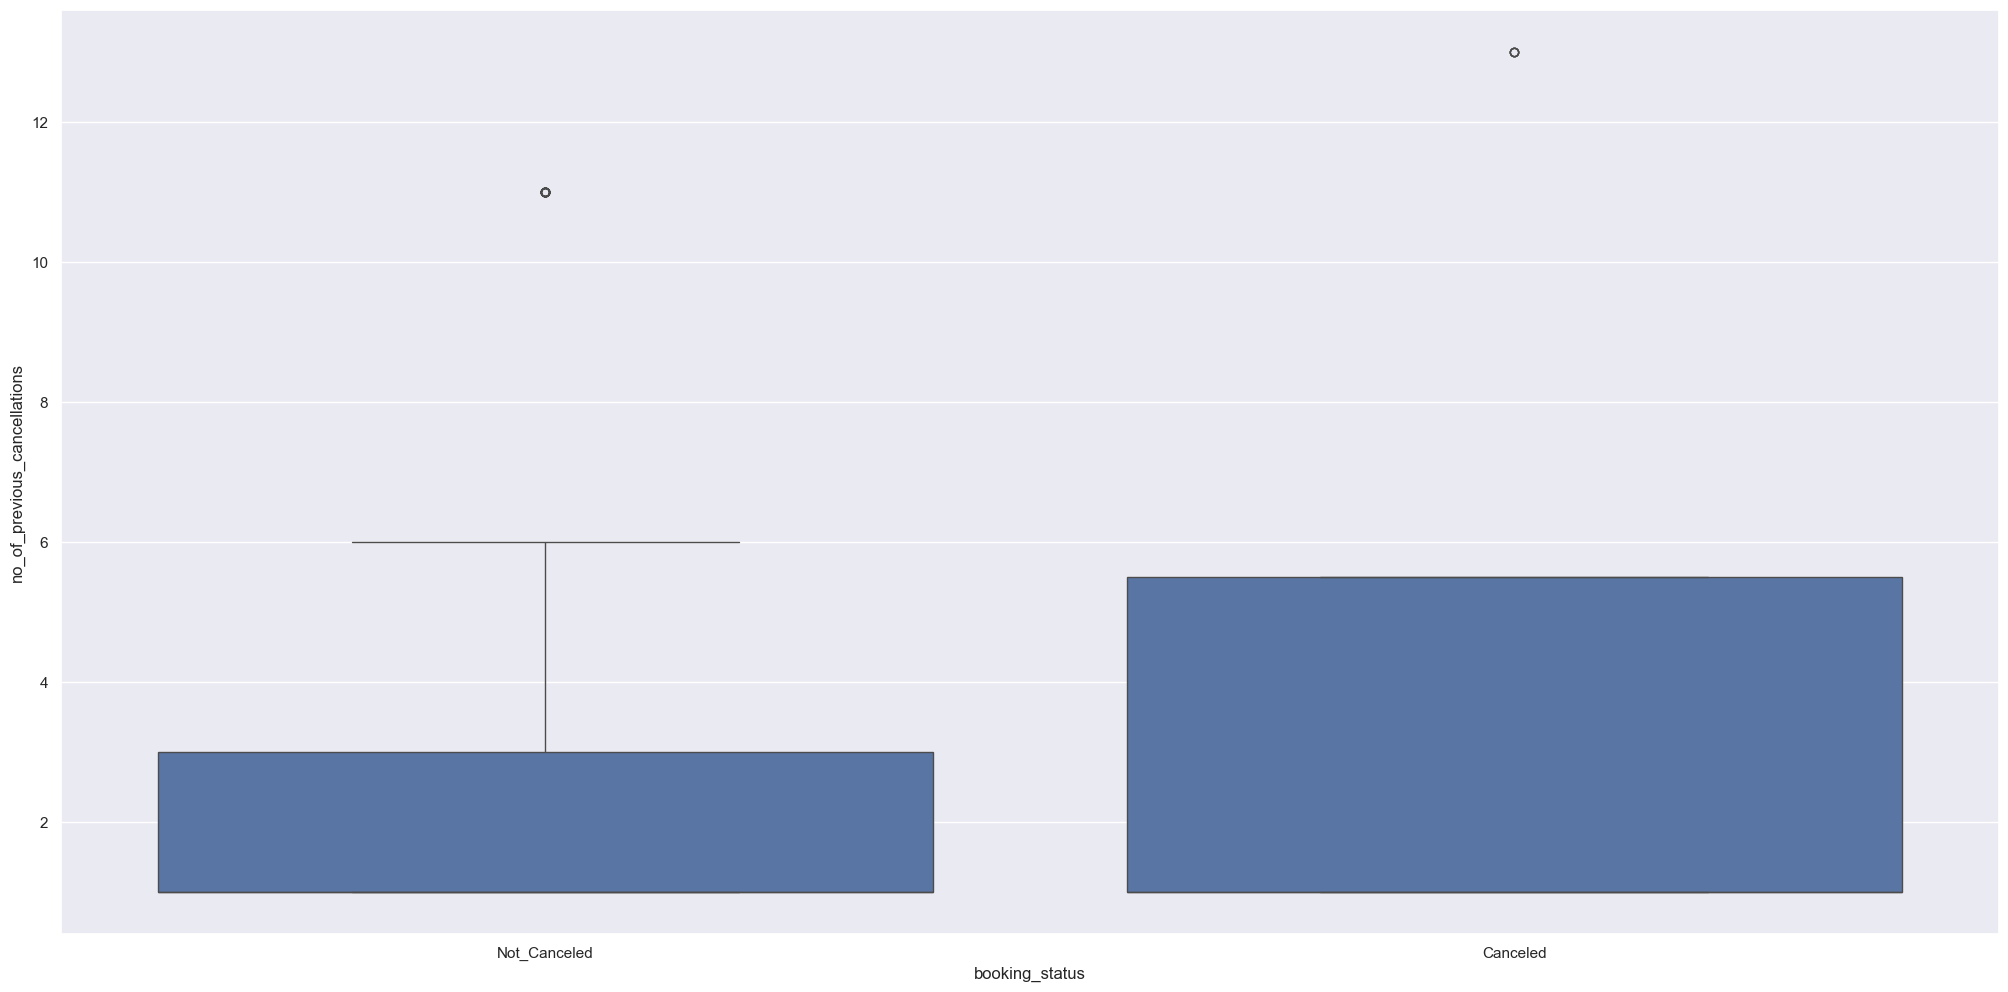

In [35]:
sns.boxplot(x = 'booking_status', y = 'no_of_previous_cancellations', data = df3[df3['no_of_previous_cancellations'] > 0])
plt.show();

##### - Pessoas com crianças na reserva têm maior probabilidade de cancelamento;

FALSA. O comportamento em ambos os grupos é quase idêntico.


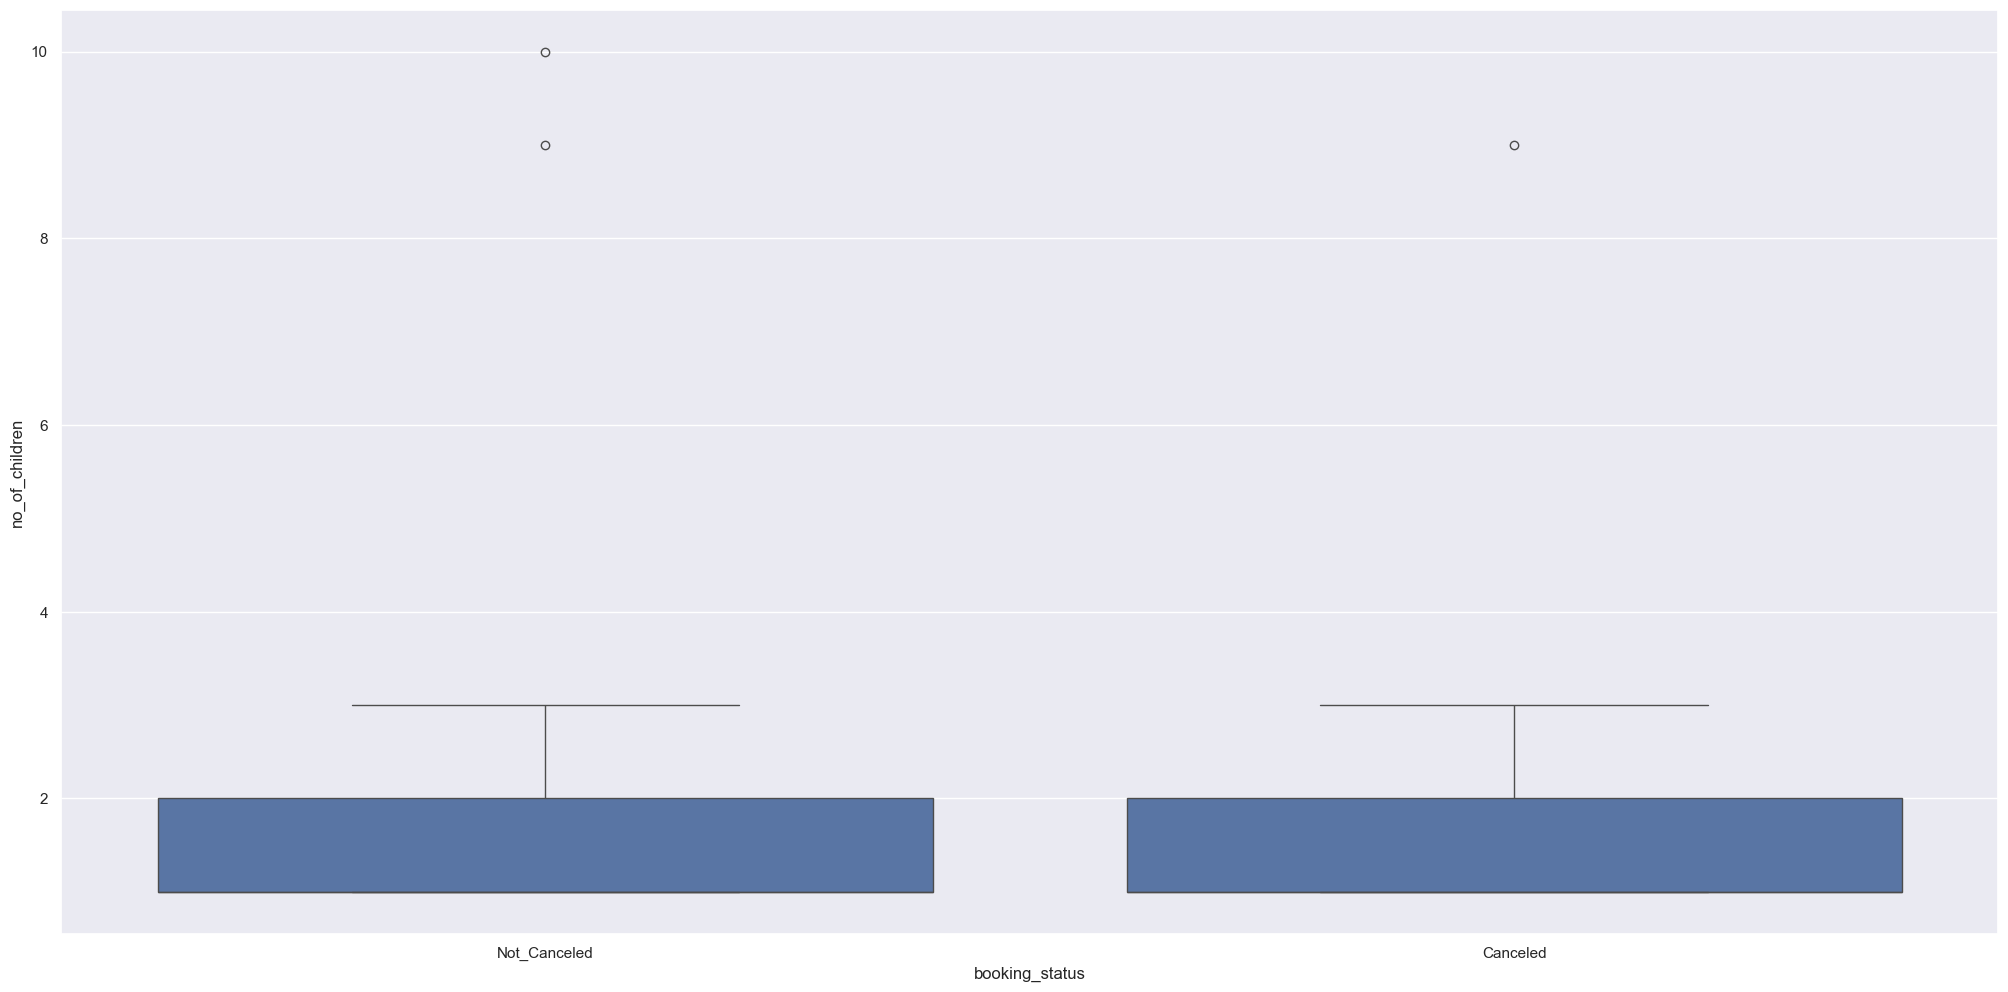

In [36]:
sns.boxplot(x = 'booking_status', y = 'no_of_children', data = df3.loc[(df3['no_of_children'] > 0)])
plt.show();

##### - Pessoas com maior quantidade de adultos na reserva têm menor probabilidade de cancelar;

FALSA. Os grupos são quase idênticos.

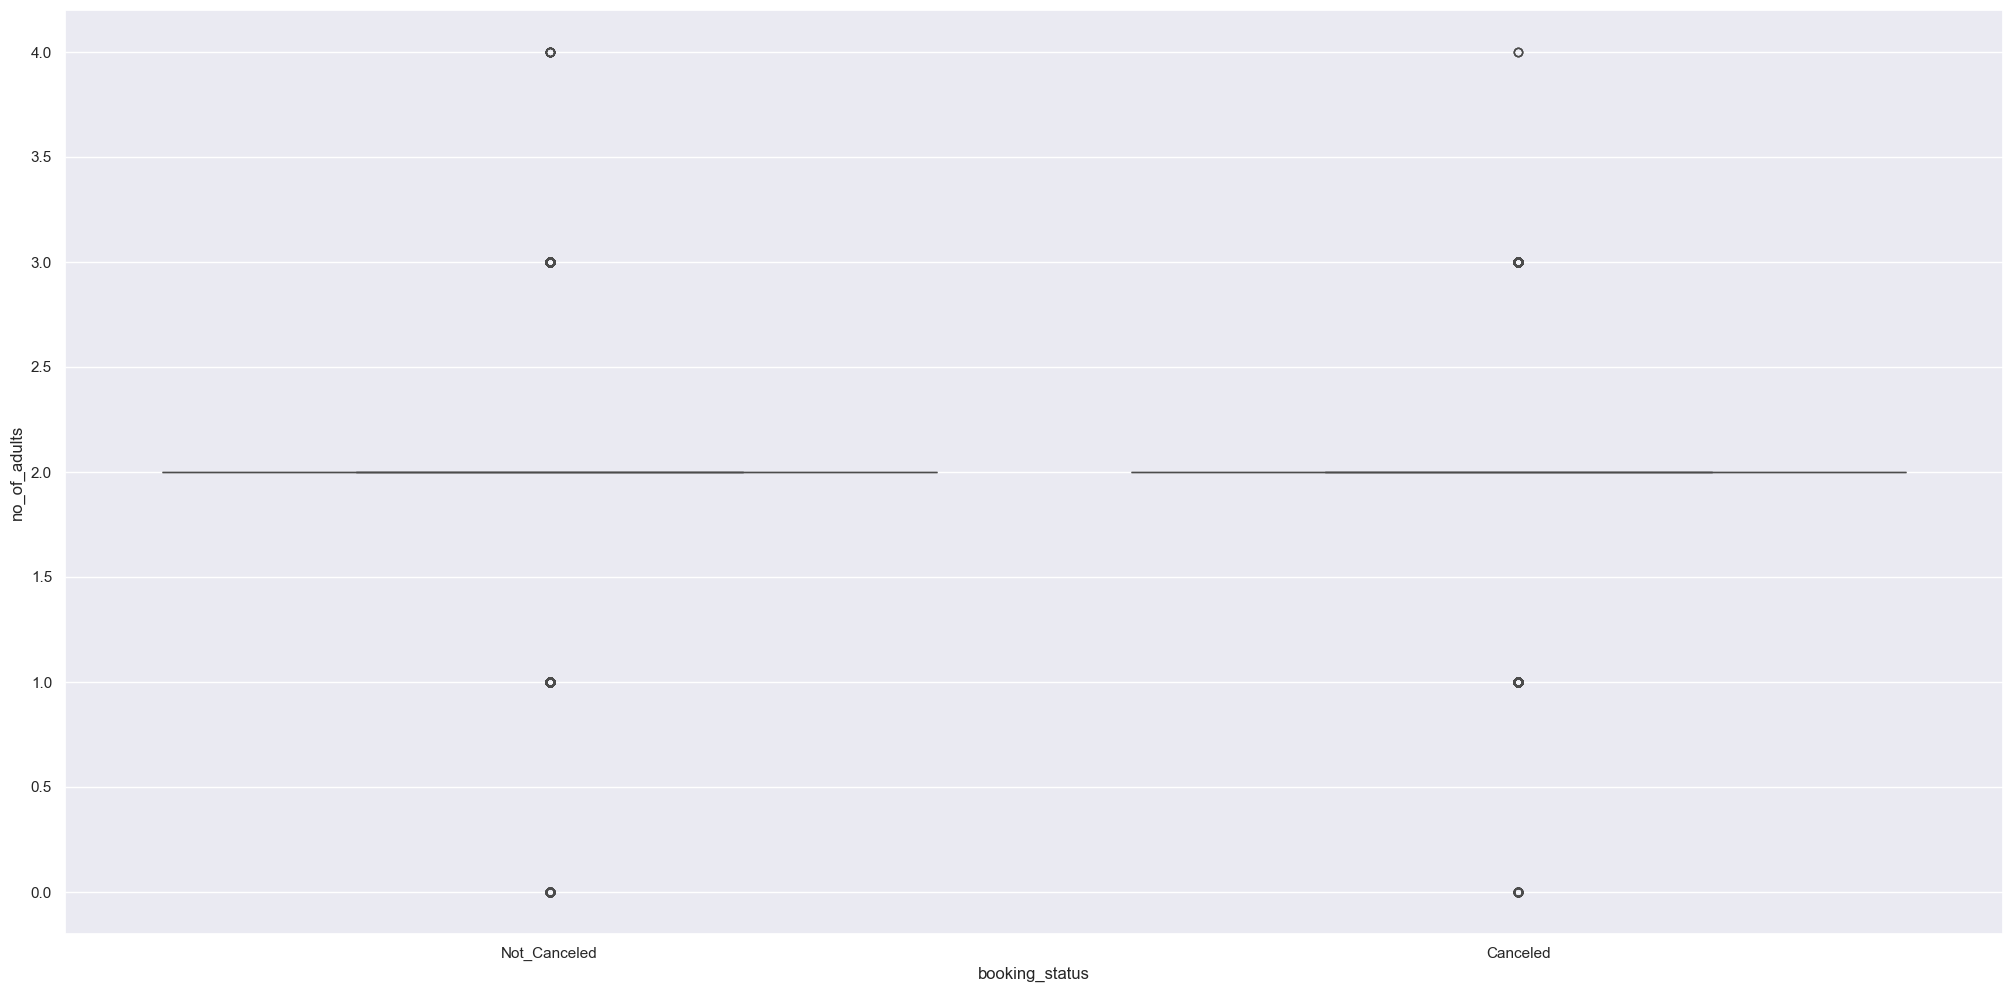

In [37]:
sns.boxplot(x = 'booking_status', y = 'no_of_adults', data = df3)
plt.show();

##### - Pessoas com registros anteriores de inadimplência podem ter uma maior probabilidade de inadimplência no futuro, indicando tendência de comportamento de risco:

FALSA. 

#### 3.2.2 Hipóteses da reserva

##### - Reservas feitas com muita antecedência tendem a serem canceladas;

VERDADEIRA. A média, mediana, o desvio-padrão e o intervalo interquartílico do grupo booking_status == 'Canceled' é maior do que as estatísticas do grupo 'Not_Canceled'

In [38]:
aux_canceled = df3[df3['booking_status'] == 'Canceled'][['booking_status', 'lead_time']]
aux_not_canceled = df3[df3['booking_status'] == 'Not_Canceled'][['booking_status', 'lead_time']]

In [39]:
estatisticas(aux_canceled)

,feature,quantidade,média,desvio-padrão,minimo,1Q,2Q,3Q,máximo,mediana,IQR
0,lead_time,11885.0,139.215482,98.947731,0.0,55.0,122.0,205.0,443.0,122.0,150.0


In [40]:
estatisticas(aux_not_canceled)

,feature,quantidade,média,desvio-padrão,minimo,1Q,2Q,3Q,máximo,mediana,IQR
0,lead_time,24390.0,58.927224,64.028714,0.0,10.0,39.0,86.0,386.0,39.0,76.0


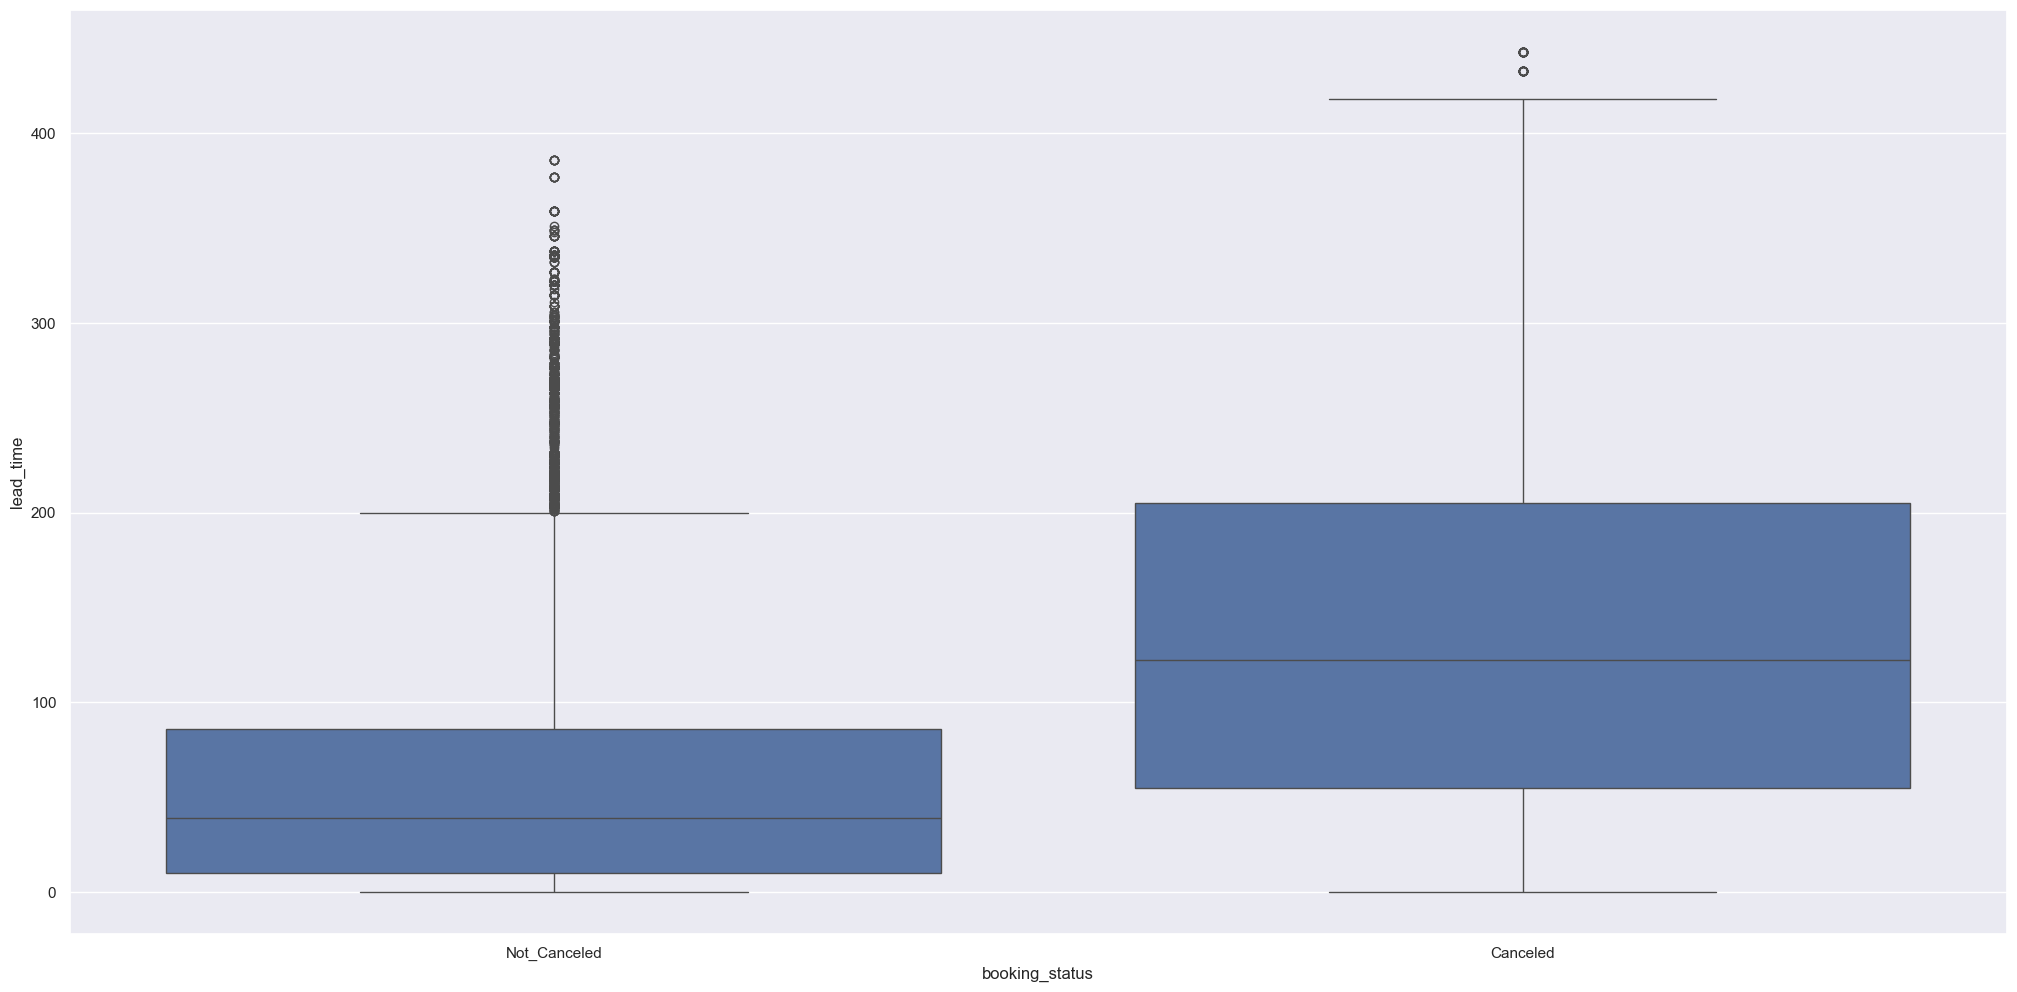

In [41]:
sns.boxplot(x = 'booking_status', y = 'lead_time', data = df3)
plt.show();

##### - Quanto maior o preço médio do quarto, maior a probabilidade de cancelamento;

NÃO FOI POSSÍVEL CONCLUIR. Ambas distribuições são muito próximas. No próximo ciclo CRISP: fazer teste de significância.

#### Conclusão:

Das 12 hipóteses levantadas, analisei 6. As demais ficam para o próximo ciclo CRISP.

### 3.3 Análise Multivariada

#### 3.3.1 Atributos Numéricos

In [42]:
num_attributes3 = df3.select_dtypes(exclude = ['object', 'category'])

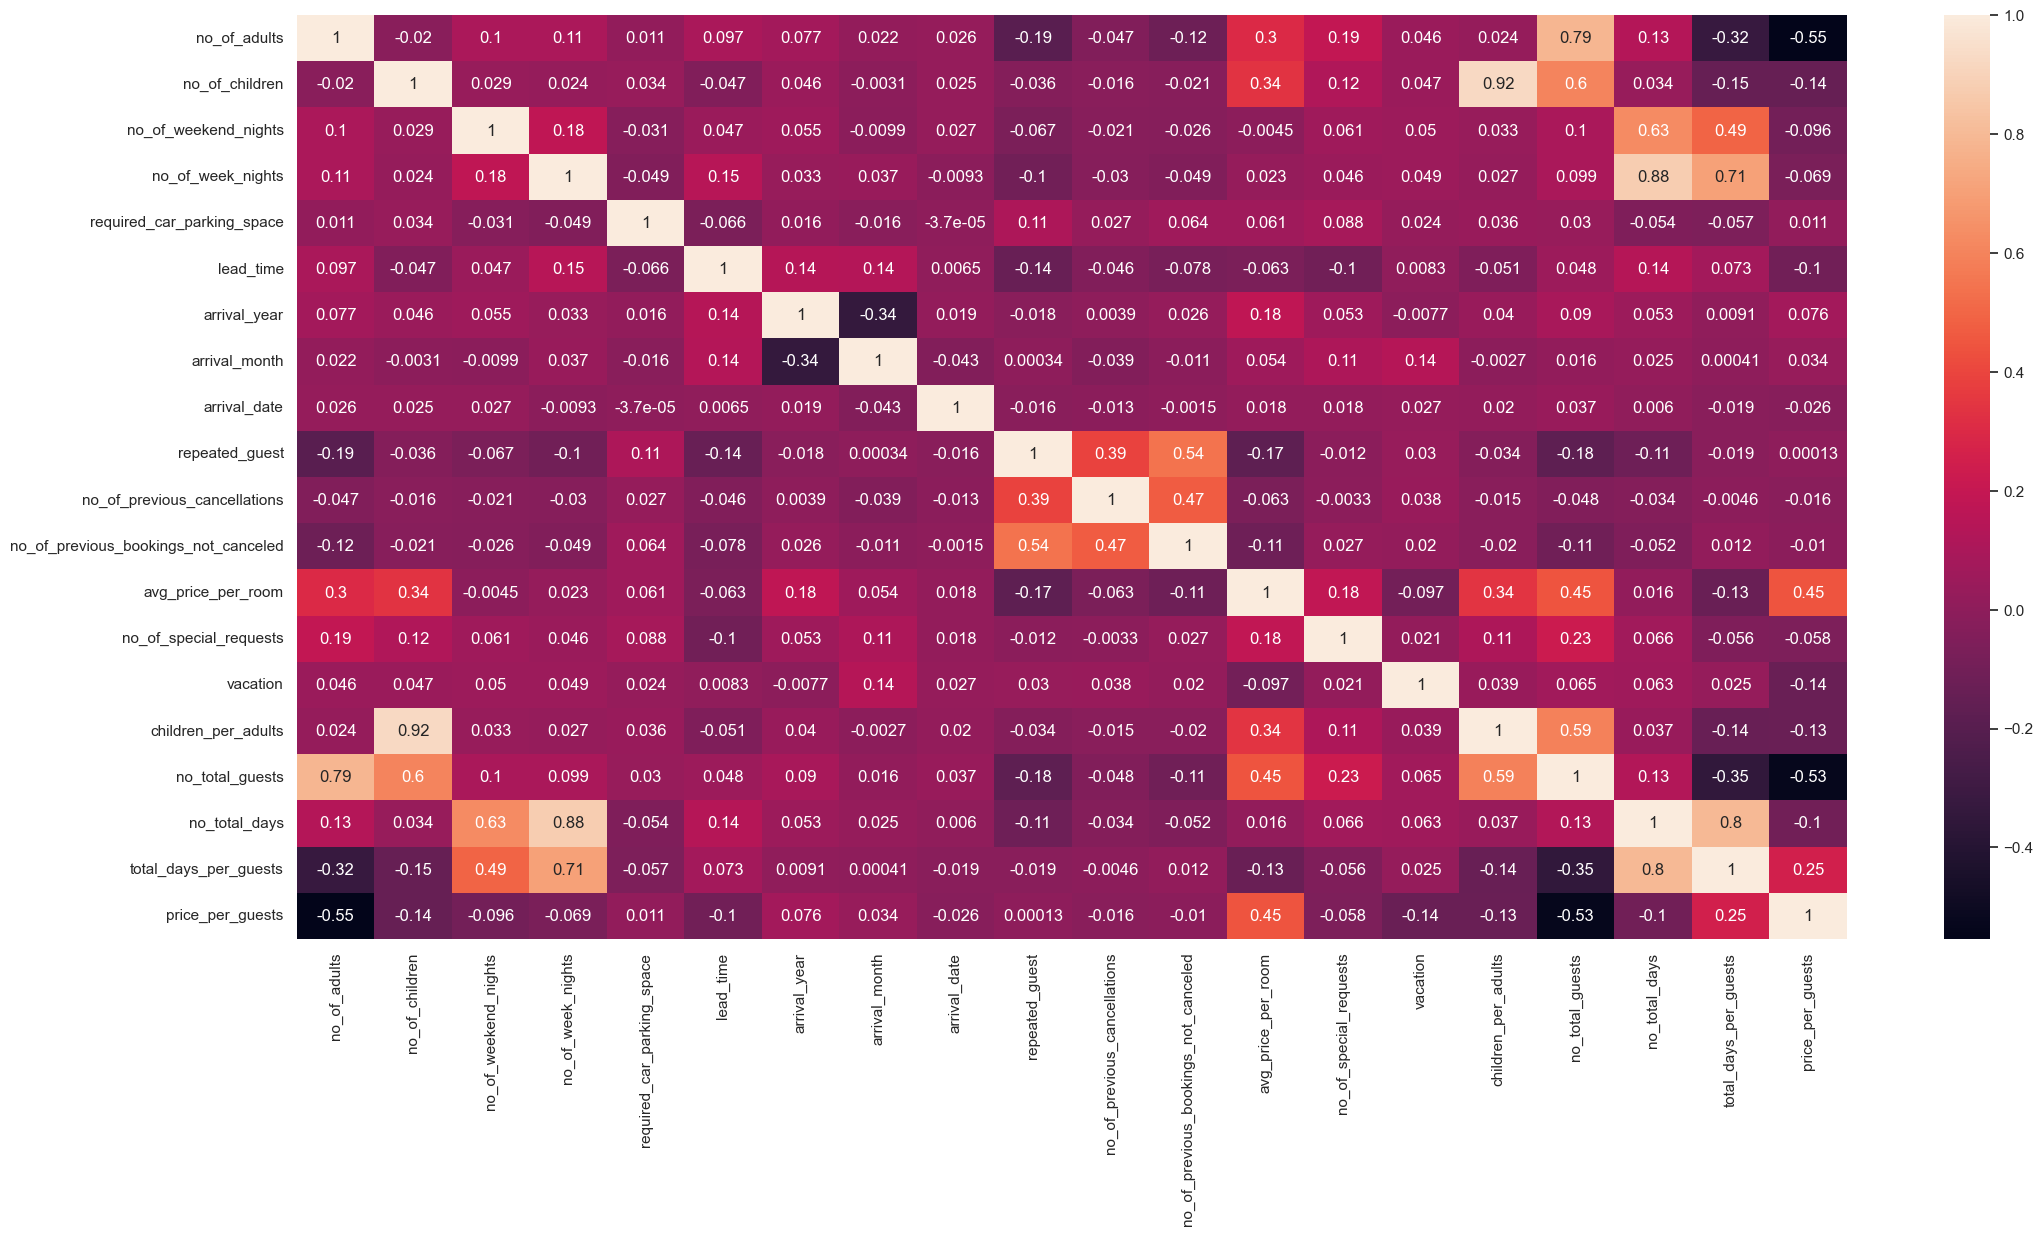

In [43]:
correlation = num_attributes3.corr(method = 'pearson')

sns.heatmap(correlation, annot = True)
plt.show();

##### Insights:

De um modo geral, a correlação entre as variáveis numéricas é baixa. Exceto para a feature no_of_children e children_per_adults.

#### 3.3.2 Atributos Categóricos

In [44]:
warnings.filterwarnings('ignore')

In [45]:
aux = df3.copy()
aux['booking_status'] = aux['booking_status'].astype(str)

a = aux.select_dtypes(include  = ['object', 'category'])

categorical_columns = a.columns

In [46]:
df = a[categorical_columns].apply(lambda x: x.astype('category') if x.dtype == "object" else x).copy()

In [47]:
cramers_v = am.CramersV(df)
cramers_v_matrix = cramers_v.fit()

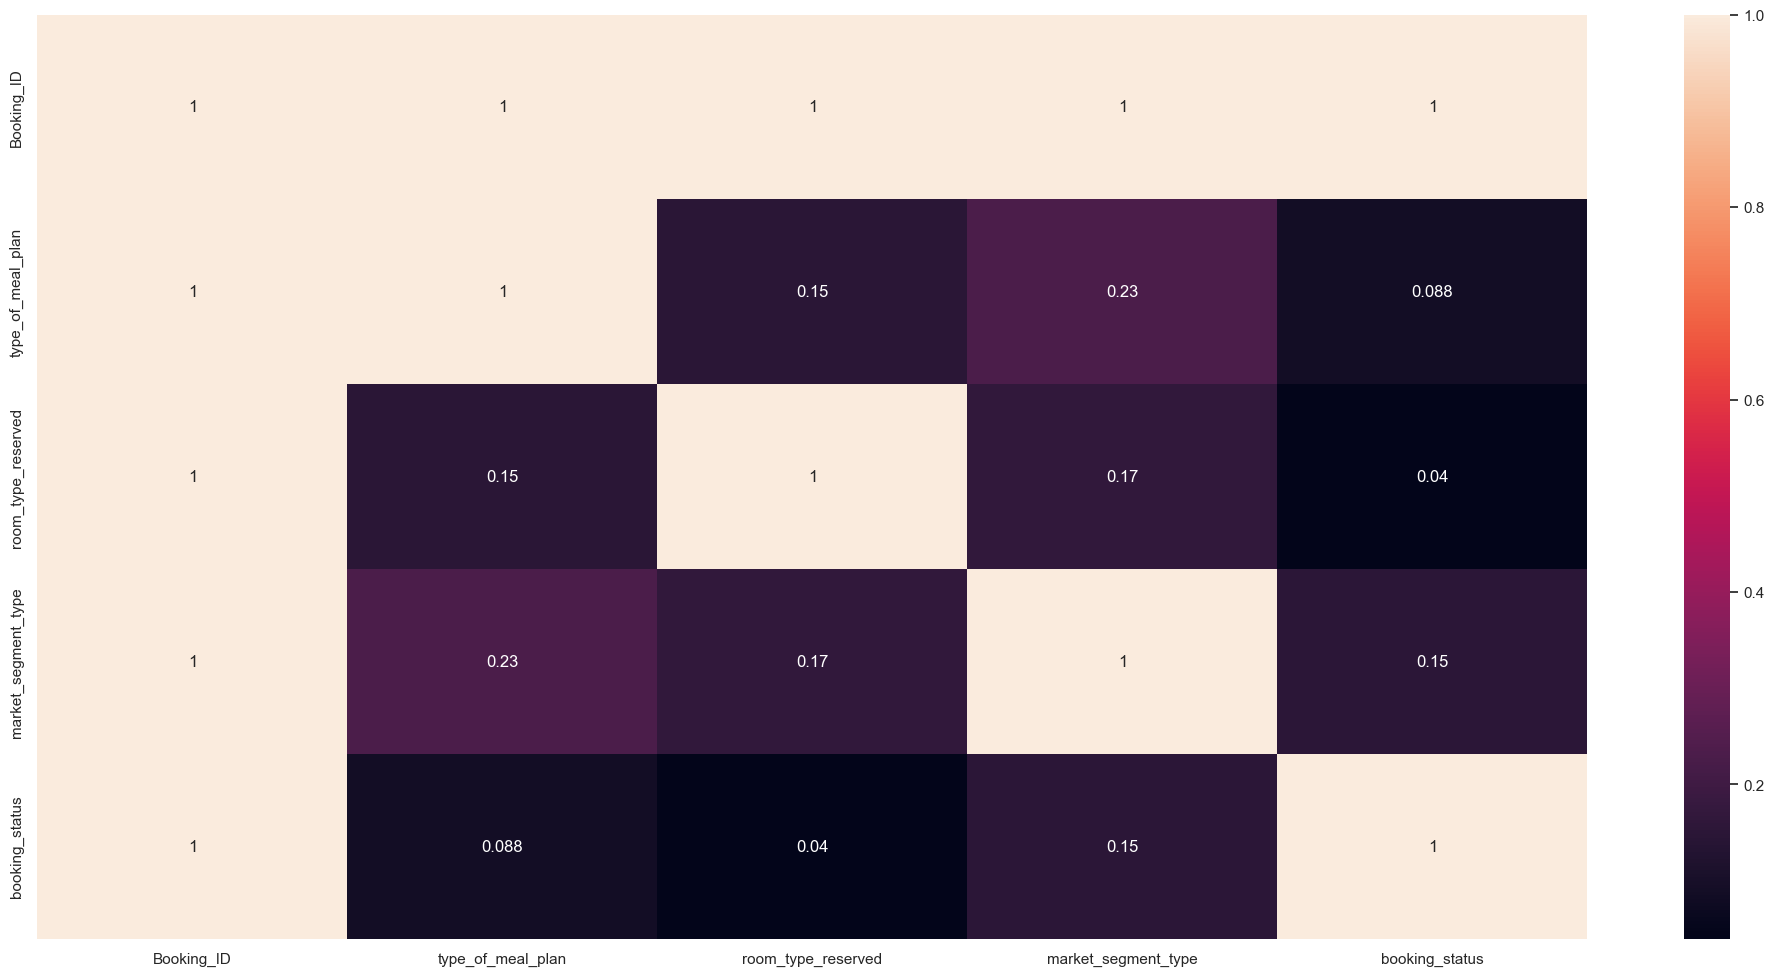

In [48]:
sns.heatmap(cramers_v_matrix, annot = True)
plt.show();

##### Insights: 

É necessário excluir o Booking_ID antes da modelagem dos dados.

A correlação entre as features categóricas é baixa.

## 4.0 Modelagem de Dados:

In [49]:
df4 = df3.drop('Booking_ID', axis = 1)

### 4.1 Preparação dos dados (rescaling e encoding)

Técnica: 
- Robust Scaler: utiliza a mediana e os quartis. Não é sensível a outliers.

In [50]:
robust_columns = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'required_car_parking_space', 'lead_time',
       'arrival_year', 'arrival_month', 'arrival_date', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'vacation',
       'children_per_adults', 'no_total_guests', 'no_total_days',
       'total_days_per_guests', 'price_per_guests']

df4 = rescale_columns(df4, robust_columns, scaler_type='robust')


### 4.3 Encoding:

- One-Hot Encoding: boa para estados (frio, quente; feriado ou não; ). Fácil implementação. Desvantagem: cria muitas colunas
- Label Encoding: cada categoria recebe um valor de 1 a n , onde n é o número de categorias. Fácil implementação, quando não há hierarquia entre as categorias.
- Ordinal Encoding: mantém a hierarquia entre as categorias (codificação ordinal). É necessário conhecer as hierarquias
- Target Encoding: rótulos correlacionados com a variável alvo
- Frequency Encoding: utiliza a frequência da categoria como rótulo


In [51]:
label_columns = ['type_of_meal_plan', 'room_type_reserved',
       'market_segment_type']

df4 = rescale_columns(df4, label_columns, scaler_type='label')

## 5.0 Seleção dos Atributos

In [52]:
df5 = df4.copy()

### 5.1 BORUTA

In [53]:
X = df5.drop(columns = ['booking_status'])
y = df5['booking_status']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15, random_state=42)

In [54]:
rf = RandomForestClassifier(n_jobs=1)

boruta = BorutaPy(rf, n_estimators='auto', verbose = 2, random_state=42).fit(X_train.values, y_train.values.ravel())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	16


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	16


In [55]:
cols_selected = boruta.support_.tolist()
cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()

In [56]:
cols_selected_boruta

['lead_time',
 'arrival_month',
 'arrival_date',
 'market_segment_type',
 'avg_price_per_room',
 'no_of_special_requests',
 'price_per_guests']

In [57]:
boruta_columns = ['lead_time',
 'arrival_month',
 'arrival_date',
 'market_segment_type',
 'avg_price_per_room',
 'no_of_special_requests',
 'price_per_guests']

## 6.0 Algoritmos de Machine Learning

In [58]:
df6 = df5.copy()

In [59]:
#tranformando a variável alvo em numérica:

df6['booking_status'] = df6['booking_status'].apply(lambda x: 1 if x == 'Canceled' else 0)

In [60]:
X = df6[boruta_columns]
y = df6['booking_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

#### 6.1 Random Forest

In [61]:
#definir o modelo
rf = RandomForestClassifier()

#treinar o modelo
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

#avaliar performance
metrics_rf = calculate_metrics("Random Forest", y_test, rf_pred)

In [62]:
metrics_rf

,Algoritmo,Precisão,Recall,Acurácia
0,Random Forest,0.869723,0.808749,0.897648


##### Cross-Validation

In [63]:
rf_cv = cross_validation_kfold(rf, X, y)

In [64]:
rf_cv

,model,precision,recall
0,RandomForestClassifier,0.865179,0.799024


#### 6.2 Decision Tree

In [65]:
#definir o modelo
dt = DecisionTreeClassifier()

#treinar o modelo
dt.fit(X_train, y_train)

dt_pred = dt.predict(X_test)

#avaliar performance
metrics_dt = calculate_metrics("Decision Tree", y_test, dt_pred)

In [66]:
metrics_dt

,Algoritmo,Precisão,Recall,Acurácia
0,Decision Tree,0.795975,0.798654,0.866961


##### Cross-Validation:

In [67]:
dt_cv = cross_validation_kfold(dt, X, y)
dt_cv

,model,precision,recall
0,DecisionTreeClassifier,0.783286,0.790198


#### 6.3 LightGBM Classifier

In [68]:
#definir o modelo
lg = lgb.LGBMClassifier()

#treinar o modelo
lg.fit(X_train, y_train)

lg_pred = lg.predict(X_test)

#avaliar performance
metrics_lg = calculate_metrics('LGBM', y_test, lg_pred)

[LightGBM] [Info] Number of positive: 10102, number of negative: 20731
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 811
[LightGBM] [Info] Number of data points in the train set: 30833, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.327636 -> initscore=-0.718897
[LightGBM] [Info] Start training from score -0.718897


In [69]:
metrics_lg

,Algoritmo,Precisão,Recall,Acurácia
0,LGBM,0.853719,0.779024,0.883866


##### Cross-Validation

In [70]:
lg_cv = cross_validation_kfold(lg, X, y)

lg_cv

[LightGBM] [Info] Number of positive: 9469, number of negative: 19551
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 809
[LightGBM] [Info] Number of data points in the train set: 29020, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.326292 -> initscore=-0.725003
[LightGBM] [Info] Start training from score -0.725003
[LightGBM] [Info] Number of positive: 9533, number of negative: 19487
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 810
[LightGBM] [Info] Number of data points in the train set: 29020, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.328498 -> initscore=-0.714988
[LightGB

,model,precision,recall
0,LGBMClassifier,0.843939,0.765417


#### 6.4 XGBoost

In [71]:
#definir o modelo
xg = xgb.XGBClassifier()

#treinar o modelo
xg.fit(X_train, y_train)

xg_pred =xg.predict(X_test)

#avaliar performance
metrics_xg = calculate_metrics('XGBoost', y_test, xg_pred)

In [72]:
metrics_xg

,Algoritmo,Precisão,Recall,Acurácia
0,XGBoost,0.857849,0.778463,0.885153


##### Cross-Validation

In [73]:
xg_cv = cross_validation_kfold(xg, X, y)

xg_cv

,model,precision,recall
0,XGBClassifier,0.848423,0.783105


#### 6.5 Regressão Logística

In [74]:
#definir o modelo
lr = LogisticRegression()

#treinar o modelo
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)

#avaliar performance
metrics_lr = calculate_metrics('Logistic Regression', y_test, lr_pred)

In [75]:
metrics_lr

,Algoritmo,Precisão,Recall,Acurácia
0,Logistic Regression,0.764376,0.611329,0.810915


##### Cross-Validation

In [76]:
lr_cv = cross_validation_kfold(lr, X, y)

lr_cv

,model,precision,recall
0,LogisticRegression,0.74124,0.60405


### Resultados

In [77]:
df_metrics = pd.concat([metrics_rf, metrics_dt, metrics_lg, metrics_xg, metrics_lr])
df_metrics.sort_values('Precisão', ascending=False)

,Algoritmo,Precisão,Recall,Acurácia
0,Random Forest,0.869723,0.808749,0.897648
0,XGBoost,0.857849,0.778463,0.885153
0,LGBM,0.853719,0.779024,0.883866
0,Decision Tree,0.795975,0.798654,0.866961
0,Logistic Regression,0.764376,0.611329,0.810915


#### Cross-Validation

In [78]:
df_metrics_cv = pd.concat([rf_cv, dt_cv, lg_cv, xg_cv, lr_cv])
df_metrics_cv.sort_values('precision', ascending=False)

,model,precision,recall
0,RandomForestClassifier,0.865179,0.799024
0,XGBClassifier,0.848423,0.783105
0,LGBMClassifier,0.843939,0.765417
0,DecisionTreeClassifier,0.783286,0.790198
0,LogisticRegression,0.741240,0.604050


## 7.0 Fine Tunning

In [79]:
param_grid = {'n_estimators': [50, 100, 200],
              'num_leaves': [20, 30, 40],
              'max_depth': [5,10,-1],
              'min_child_samples': [20,30,50],
              'subsample': [0.6, 0.8, 1,0],
              'colsample_bytree': [0.6, 0.8 , 1.0]}

### 7.3 Bayes Search

In [80]:
def rf_cv(n_estimators, max_depth, min_samples_leaf):

    params = {'n_estimators': int(n_estimators),
              'max_depth': int(max_depth),
              'min_samples_leaf': int(min_samples_leaf)}
    rf = RandomForestClassifier(**params)
    cv_results = cross_val_score(rf, X_train, y_train, cv = 5, scoring= 'recall').mean()

    return cv_results

In [81]:
pbounds = {'n_estimators': (50,200),
           'max_depth': (3,10),
           'min_samples_leaf': (10,50)}

optimizer = BayesianOptimization(
    f = rf_cv,
    pbounds= pbounds,
    random_state= 42
)

optimizer.maximize(init_points=5, n_iter=50)

|   iter    |  target   | n_esti... | max_depth | min_sa... |
-------------------------------------------------------------
| 2         | 0.6760023 | 106.18101 | 9.6550001 | 39.279757 |
| 3         | 0.4487181 | 139.79877 | 4.0921304 | 16.239780 |
| 4         | 0.6830297 | 58.712541 | 9.0632330 | 34.044600 |
| 5         | 0.3703234 | 156.21088 | 3.1440914 | 48.796394 |
| 6         | 0.4349609 | 174.86639 | 4.4863737 | 17.272998 |
| 7         | 0.6637280 | 57.852707 | 8.2680207 | 34.097980 |
| 8         | 0.7007493 | 73.614516 | 10.0      | 34.575999 |
| 9         | 0.7203502 | 68.080712 | 10.0      | 15.205308 |
| 10        | 0.7253979 | 92.791075 | 10.0      | 10.736196 |
| 11        | 0.3800221 | 93.545133 | 3.0       | 25.208685 |
| 12        | 0.7109448 | 66.510790 | 10.0      | 25.615287 |
| 13        | 0.7254973 | 80.226192 | 10.0      | 10.0      |
| 14        | 0.6785761 | 67.325237 | 10.0      | 50.0      |
| 15        | 0.6773882 | 118.42276 | 10.0      | 50.0      |
| 16    

In [82]:
print('Melhores Parâmetros:')
print(optimizer.max)

Melhores Parâmetros:
{'target': 0.7257937693818862, 'params': {'n_estimators': 200.0, 'max_depth': 10.0, 'min_samples_leaf': 10.0}}


In [83]:
best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])

rf_best  = RandomForestClassifier(**best_params)
rf_best.fit(X_train, y_train)

print('Precisão em dados de teste: ', mt.precision_score(y_test, rf_best.predict(X_test)))
print('Recall em dados de teste: ', mt.recall_score(y_test, rf_best.predict(X_test)))

Precisão em dados de teste:  0.8557692307692307
Recall em dados de teste:  0.7487380818844643


In [84]:
optimizer.max['params']

{'n_estimators': 200.0, 'max_depth': 10.0, 'min_samples_leaf': 10.0}

## 8.0 Final Model

In [85]:
best_params = {'n_estimators': 89,
 'max_depth': 10,
 'min_samples_leaf': 10}

In [86]:
model_tunned = RandomForestClassifier(**best_params).fit(X_train, y_train)
y_pred = model_tunned.predict(X_test)

In [87]:
print('Precisão em dados de teste: ', mt.precision_score(y_test, y_pred))
print('Recall em dados de teste: ', mt.recall_score(y_test, y_pred))

Precisão em dados de teste:  0.85297845373891
Recall em dados de teste:  0.754907459338194


In [88]:
X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

In [89]:
final_model = RandomForestClassifier(**best_params).fit(X_full, y_full)

In [90]:
pickle.dump(final_model, open('final_model.pkl', 'wb'))

## 9.0 Tradução do erro para resultado de negócio

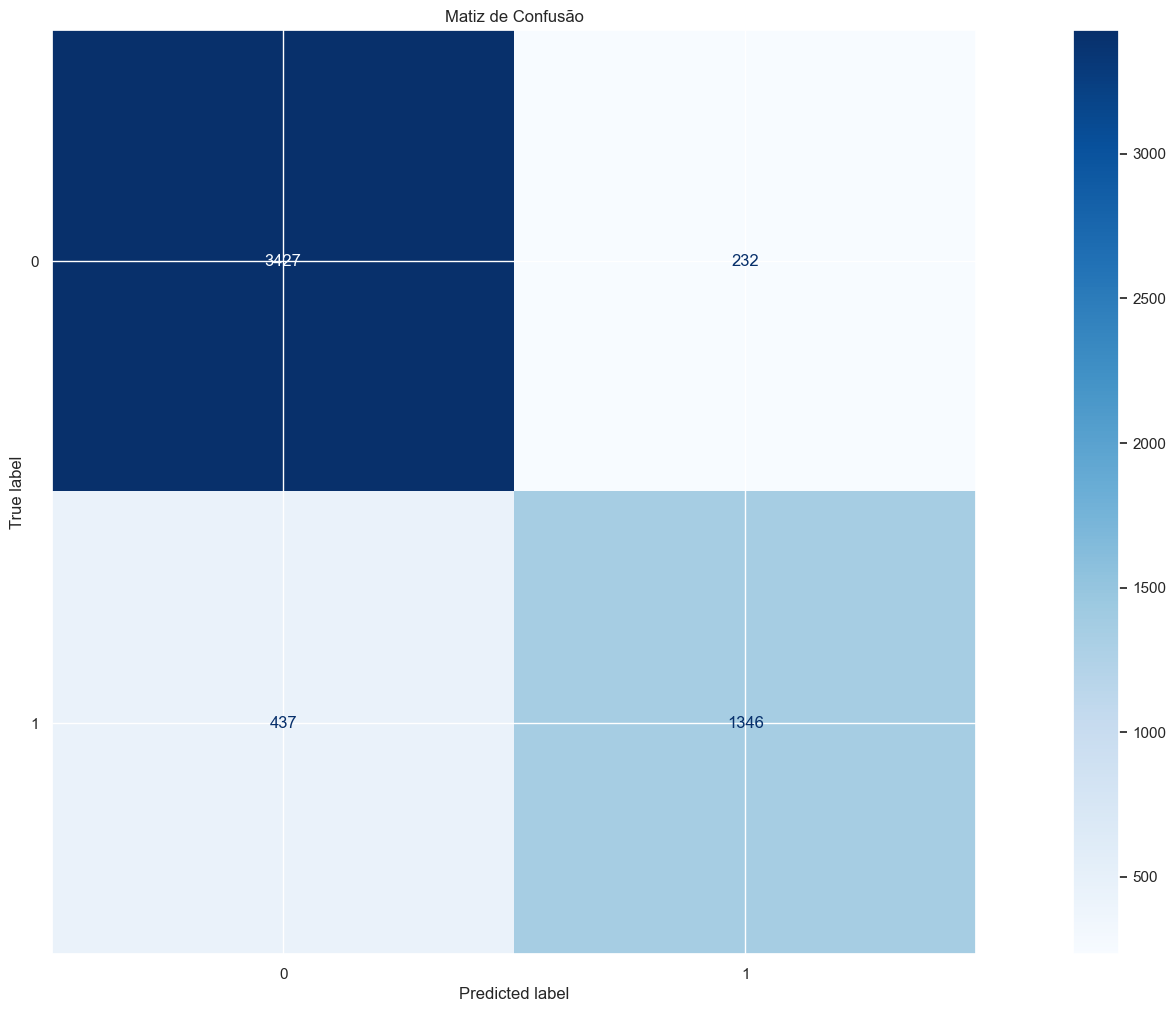

In [91]:
#Matriz de Confusão:

cm = mt.confusion_matrix(y_test, y_pred)
disp = mt.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['0', '1'])
disp.plot(cmap = 'Blues')
plt.title("Matiz de Confusão")
plt.show()

In [92]:
precision = 0.8539

custo_medio = 3500
reservas_canceladas = 50000*0.3276
verdadeiros_positivos_modelo = reservas_canceladas*precision
falsos_positivos_modelo = reservas_canceladas*(1-precision)

custo_atual = custo_medio*reservas_canceladas
economia_com_modelo = custo_medio*verdadeiros_positivos_modelo
custo_com_modelo = custo_medio*falsos_positivos_modelo


print(f'Sem o modelo, o custo dos cancelamentos das reservas pode chegar a R$ {custo_atual} no próximo ano.')
print(f'Com o modelo, o custo com as reservas canceladas pode cair até R$ {custo_com_modelo} no próximo ano.')
print(f'Nesse cenário, se a empresa conseguir evitar todos os cancelamentos indicados pelo modelo, a economia pode chegar até R$ {economia_com_modelo} no próximo ano.')


Sem o modelo, o custo dos cancelamentos das reservas pode chegar a R$ 57330000.0 no próximo ano.
Com o modelo, o custo com as reservas canceladas pode cair até R$ 8375913.0 no próximo ano.
Nesse cenário, se a empresa conseguir evitar todos os cancelamentos indicados pelo modelo, a economia pode chegar até R$ 48954087.0 no próximo ano.


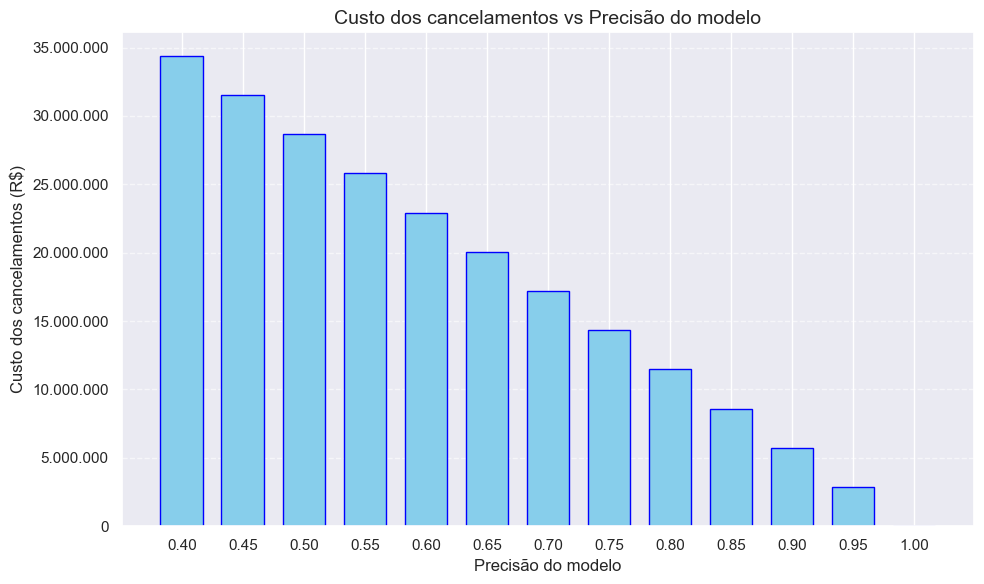

In [120]:
# Função para formatar os números com separador de milhar
def milhar(x, pos):
    return f'{int(x):,}'.replace(',', '.')

# Valores fixos
custo_medio = 3500
reservas_canceladas = 50000 * 0.3276

# Precisões discretas
precisoes = np.arange(0.4, 1.05, 0.05)

# Custos com modelo
custos = custo_medio * reservas_canceladas * (1 - precisoes)

# Plot do gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(precisoes, custos, width=0.035, color='skyblue', edgecolor='blue')

plt.title('Custo dos cancelamentos vs Precisão do modelo', fontsize=14)
plt.xlabel('Precisão do modelo', fontsize=12)
plt.ylabel('Custo dos cancelamentos (R$)', fontsize=12)

# Aplicando o formatador de milhar
formatter = FuncFormatter(milhar)
plt.gca().yaxis.set_major_formatter(formatter)

plt.xticks(precisoes, [f'{p:.2f}' for p in precisoes])
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## 10.0 Deploy to Production

In [109]:
class PredictEmprestimo(object):
    def __init__(self):
        self.lead_time               = pickle.load(open('parameter/lead_time_robust.pkl', 'rb'))
        self.arrival_month           = pickle.load(open('parameter/arrival_month_robust.pkl', 'rb'))
        self.arrival_date            = pickle.load(open('parameter/arrival_date_robust.pkl', 'rb'))
        self.market_segment_type     = pickle.load(open('parameter/market_segment_type_labelencoder.pkl', 'rb'))
        self.avg_price_per_room      = pickle.load(open('parameter/avg_price_per_room_robust.pkl', 'rb'))
        self.no_of_special_requests  = pickle.load(open('parameter/no_of_special_requests_robust.pkl', 'rb'))
        self.price_per_guests        = pickle.load(open('parameter/price_per_guests_robust.pkl', 'rb'))
        
    def data_cleaning(self, df1):
        num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
        cat_attributes = df1.select_dtypes(include = ['object', 'category'])
        if num_attributes.isna().any().any():
            df_imputed = pd.DataFrame(self.imputer.transform(num_attributes), columns = num_attributes.columns)
            df1 = pd.concat([df_imputed, cat_attributes], axis = 1)
        else:
            return df1
        return df1

    def feature_engineering(self, df2):
        #quantidade total de pessoas:
        df2['no_total_guests'] = df2['no_of_children'] + df2['no_of_adults']
        
        #proporção média do preço do quarto por total de hóspedes:
        df2['price_per_guests'] = df2['avg_price_per_room'] / df2['no_total_guests']

        #tranformando a variável alvo em numérica:
        df2['booking_status'] = df2['booking_status'].apply(lambda x: 1 if x == 'Canceled' else 0)

        return df2

    def data_preparation(self, df3):
        df3['lead_time'] = self.lead_time.transform(df3[['lead_time']])
        df3['arrival_month'] = self.arrival_month.transform(df3[['arrival_month']])
        df3['arrival_date'] = self.arrival_date.transform(df3[['arrival_date']])
        df3['market_segment_type'] = self.market_segment_type.transform(df3[['market_segment_type']])
        df3['avg_price_per_room'] = self.avg_price_per_room.transform(df3[['avg_price_per_room']])
        df3['no_of_special_requests'] = self.no_of_special_requests.transform(df3[['no_of_special_requests']])
        df3['price_per_guests'] = self.price_per_guests.transform(df3[['price_per_guests']])
                     
        boruta_columns = ['lead_time',
                        'arrival_month',
                        'arrival_date',
                        'market_segment_type',
                        'avg_price_per_room',
                        'no_of_special_requests',
                        'price_per_guests']

        return df3[boruta_columns] 

    def get_predictions(self, model, test_data, original_data):
        pred = model.predict(test_data)
        original_data['prediction'] = pred

        return original_data.to_json(orient = 'records')

## 11.0 API Handler

In [110]:
from flask import Flask, request, Response
import os


model = pickle.load(open('final_model.pkl', 'rb'))

app = Flask(__name__)

@app.route('/empresa/predict', methods = ['POST'])
def emprestimo_predict():
    test_json = request.get_json()

    if test_json:
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index =[0])
        else:
            test_raw =  pd.DataFrame(test_json, columns = test_json[0].keys())

        pipeline = PredictEmprestimo()
        df_feature = pipeline.feature_engineering(test_raw)
        df_cleaning = pipeline.data_cleaning(df_feature)
        df_preparation = pipeline.data_preparation(df_cleaning)
        df_predict = pipeline.get_predictions(model, df_preparation, test_raw)

        return df_predict
    
    else:
        return Response('{}', status = 200, mimetype='aplication/json')
    
if __name__ == 'main':
    port = os.environ.get('PORT', 5000)
    app.run('0.0.0.0', port = port)


## Teste API

In [111]:
import json
import requests

In [112]:
# model = pickle.load(open('final_model.pkl', 'rb'))

data_test = df1.loc[df1.index == 1 ]

In [113]:
#teste local: 
data_test = df1.loc[df1.index == 20 ]
pipeline = PredictEmprestimo()
df_feature = pipeline.feature_engineering(data_test)
df_cleaning = pipeline.data_cleaning(df_feature)
df_preparation = pipeline.data_preparation(df_cleaning)
df_predict = pipeline.get_predictions(model, df_preparation, data_test)

In [103]:
url = 'http://127.0.0.1:5000/empresa/predict'
#url ='https://shiny-melosa-samantasobral-e61bca77.koyeb.app/empresa/predict'
header = {'Content-Type': 'application/json'}
data = json.dumps(data_test.to_dict(orient='records'))

r = requests.post(url, data = data, headers = header)

print('Status Code {}'.format(r.status_code))

Status Code 500


In [114]:
r.json()

JSONDecodeError: Expecting value: line 1 column 1 (char 0)